# This notebook plots figures for the paper 

In [1]:
# %pip install matplotlib-label-lines
# %pip install seaborn

In [2]:
import CoolProp.CoolProp as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
import os
import seaborn
from labellines import labelLine, labelLines
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib

pf.__version__

'0.0.80'

In [3]:
os.path.dirname(os.getcwd())

'p:\\WORK-GENERAL\\POSTDOC-UCB\\BERKELEY-VIBE\\Documents\\Projects\\Data\\Hawaii_FI\\MIFI_paper'

In [4]:
# Setting plotting parameters
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 6 # Sets length of ticks
plt.rcParams["xtick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels
plt.rcParams["pdf.fonttype"]=42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.fancybox"]=False

pd.set_option("display.max_colwidth", None)  # after this you can print any column length


def calculate_R2(x, y, xy=True, df=False, round=5,pval_format='decimal'):
    """ Calculates statistics
    if xy= False doesn't return y and x pred
    """
    masknan = (~np.isnan(x) & ~np.isnan(y))
    regx = x[masknan].values.reshape(-1, 1)
    regy = y[masknan].values.reshape(-1, 1)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(regx[:, 0], regy[:, 0])

    lr = LinearRegression()
    lr.fit(regx, regy)
    Y_pred = lr.predict(regx)
    Int = lr.intercept_[0]
    Grad = lr.coef_[0][0]

    R = r2_score(regy, Y_pred)
    RMSE = np.sqrt(np.mean((regy - Y_pred) ** 2))
    Median = np.nanmedian(regy - regx)
    Mean = np.nanmean(regy - regx)

    if pval_format=='decimal':
        p_value=format(p_value, '.'+str(round)+'f')
    
    Rp = np.round(R, round)
    RMSEp = np.round(RMSE, round)
    Medianp = np.round(Median, round)
    Meanp = np.round(Mean, round)
    Intp=np.round(Int,round)
    Gradp=np.round(Grad,round)

    output = {
        "R\u00B2": str(Rp),
        'RMSE': str(RMSEp),
        'P_val': str(p_value),
        'Int': str(Intp),
        'Grad': str(Gradp),
        'Median': str(Medianp),
        'Mean': str(Meanp)
    }
    
    if xy:
        output['x_pred'] = Y_pred.tolist()
        output['y_pred'] = regy.tolist()
    
    return output

## Stretching model functions

In [5]:
## These are functions to find the pressure corresponding to a specific depth using a DiadFit models 

from scipy.optimize import newton
import DiadFit as pf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
pf.__version__

def pressure_equation(P_kbar, target_depth, model):
    current_depth = pf.convert_pressure_to_depth(P_kbar=P_kbar, model=model)[0]
    return current_depth - target_depth

def find_P_for_kmdepth(target_depth, model, tolerance=0.1):
    initial_pressure = 0  
    pressure = newton(pressure_equation, initial_pressure, args=(target_depth, model), tol=tolerance)
    return pressure


## These are stretching model functions

## Functions that do the work
def ideal_calc_rho_for_r_P_T(*,P_MPa,T,r):
    P=P_MPa*10**6 # convert MPa to Pa
    M=44.01/1000 #kg/mol
    V=4/3*math.pi*r**3 #m3
    R=8.314 #J.mol/K J: kg·m²/s² 
    m=P*V*M/(R*T) #CO2 mass in kg
    rho=(m/V)/1000 # rho in g/cm3
    return rho, m/1000

def ideal_calc_P_for_V_rho_T(*,co2_mass_g,T,r):
    M=44.01/1000 #kg/mol
    m=co2_mass_g*1000
    V=4/3*math.pi*r**3 #m3
    R=8.314 #J.mol/K J: kg·m²/s² 
    P=m*R*T/(M*V) #P in Pa
    P_MPa=P/(10**6) #P in MPa
    rho=(m/V)/1000 #rho in g/cm3
    return rho,P_MPa


def calculate_DPdt(ascent_rate_ms,D_initial=30,D_final=0,D_step=100):
    D = pd.Series(list(np.linspace(D_initial, D_final, D_step)))  # km

    h = D * 10 ** 3  # m
    rho = 3058  # kg/m3
    g = 9.81  # m/s2
    P = rho * g * h * 10 ** -6  # MPa lithostatic pressure
    Pexternal_steps = list(P)  # These are the pressure steps

    # Time steps of the ascent
    ascent_rate = ascent_rate_ms / 1000  # km/s
    D_change = abs(D.diff())
    time_series = D_change / ascent_rate  # calculates the time in between each step based on ascent rate
    dt = time_series.max()  # this sets the time step for the integration part
    
    return D, Pexternal_steps, dt

def calculate_initial_V_CO2rho_mass(*,EOS='SW96',P,T,r):
    ### This function calculates CO2 mass as a function of P,T, and FI radius(Volume), r has to be in cm,
    ### V is output in cm3, rho in g/cm3 and mass in g
    ###
    V=4/3*math.pi*r**3 #cm3, Volume of the FI, assume sphere
    P_kbar=P/100 #Internal pressure of the FI
    CO2_dens=pf.calculate_rho_for_P_T(EOS=EOS,P_kbar=P_kbar,T_K=T)[0] #g/cm3, CO2 density, calc by Span&Wagner(96)
    CO2_mass=CO2_dens*V # this is our CO2 mass in the FI
    return V, CO2_dens, CO2_mass

def calculate_step_P_for_m_r(*,EOS='SW96',m,T,r):
    ### This function internal pressure and volume of the inclusion as a function of T, FI radius and CO2 mass, r has to be in cm,
    ### V is output in cm3, rho in g/cm3 and mass in g.
    ###
    V=4/3*math.pi*r**3 #cm3, Volume of the FI, assume sphere
    CO2_dens=m/V
    try:
        P_new=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=CO2_dens, T_K=T)['P_MPa'][0] #g/cm3, CO2 density, calc by Span&Wagner(96)
        return V, CO2_dens, P_new
    except ValueError:
        return V,CO2_dens,np.nan


class power_creep_law_constants:
    def __init__(self):
        self.A = 3.9*10**3 #7.0 * 10**4
        self.n = 3.6 #3
        self.Q = 523000 # 520 Activation energy for dislocation motions in J/mol
        self.IgasR= 8.314  # Gas constant in J/(mol*K)

# # Helper function to calculate dR/dt
def calculate_dR_dt(*,R, b, T,  Pinternal, Pexternal):
    pl_Cs = power_creep_law_constants()
    if Pinternal<Pexternal==True:
        S=-1
    else:
        S=1
    try:
        dR_dt = 2 * (S * pl_Cs.A * math.exp(-pl_Cs.Q / (pl_Cs.IgasR * T))) * (((R * b)**3) / (((b**(3 / pl_Cs.n)) - (R**(3 / pl_Cs.n))))**pl_Cs.n) * (((3 * abs(Pinternal - Pexternal)) / (2 * pl_Cs.n))**pl_Cs.n) / R**2
        return dR_dt

    except FloatingPointError:
        return np.nan

# Euler method for iterative numerical solving (range of Pext)
def findR_Pi_rho_4Pestep_euler(*,R0, b, T,D,Pexternal_steps,dt,EOS,plotfig=True,display_df=True,Pinternal=None):
    if Pinternal is None:
        Pinternal = Pexternal_steps[0]
    _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R0*10**2)
    R_values = [R0]  # List to store R values at different time points
    Pinternal_list=[Pinternal]
    CO2_dens_list=[CO2_dens_initial]
    dR_dt_list=[]
    results=pd.DataFrame(columns={'Pexternal(MPa)','Pinternal(MPa)',
                                  'Depth(km)','Fi_radius(\u03BCm)',
                                  'CO2 density (g/cm3)','dR/dt(m/s)' })
    for i in range(len(Pexternal_steps)):
        Pexternal = Pexternal_steps[i]
        dR_dt = calculate_dR_dt(R=R_values[-1], b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
        R_new = R_values[-1] + dR_dt * dt
        _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
        Pinternal=P_new
        dR_dt_list.append(dR_dt)
        R_values.append(R_new)
        Pinternal_list.append(Pinternal)
        CO2_dens_list.append(CO2_dens_new)
    
    results['Pexternal(MPa)']=Pexternal_steps
    results['Pinternal(MPa)']=Pinternal_list[1:]
    results['Depth(km)']=D
    results['Fi_radius(\u03BCm)']=[num * 10**6 for num in R_values][1:]
    results['CO2 density (g/cm3)']=CO2_dens_list[1:]
    results['dR/dt(m/s)']=dR_dt_list
    results['\u0394R/R0']=(results['Fi_radius(μm)']-results['Fi_radius(μm)'][0])/results['Fi_radius(μm)'][0]

    if display_df==True:
        display(results.head())
    if plotfig==True:
        fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
        ax0.plot(-results['Depth(km)'],results['ΔR/R0'],marker='s')
        ax0.set_xlabel("Depth")
        ax0.set_ylabel("DeltaR/R0")

        ax1.plot(-results['Depth(km)'],results['CO2 density (g/cm3)'],marker='s')
        ax1.set_xlabel("Depth")
        ax1.set_ylabel("CO2_density_gmL")

    return results, fig if 'fig' in locals() else results

def findR_Pi_rho_fixedPe_euler(*,R,b=None,T,EOS_method=None,EOS='SW96',Pinternal,Pexternal,totaltime,steps):

    dt=totaltime/steps

    if b is None:
        b=R*1000
    
    if EOS_method=='ideal':
        CO2_dens_initial,CO2_mass_initial=ideal_calc_rho_for_r_P_T(P_MPa=Pinternal,T=T,r=R*10**2)
    else:
        _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R*10**2)

    results = pd.DataFrame([{'Time(s)': 0,
                             'Step':0,
                             'dt(s)':0,
                            'Pexternal(MPa)': Pexternal,
                            'Pinternal(MPa)': Pinternal,
                            'dR/dt(m/s)': calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                            'Fi_radius(μm)': R*10**6,
                            'b (distance to xtal rim -μm)':b*10**6,
                            '\u0394R/R0 (fractional change in radius)':0,
                            'CO2 density (g/cm3)': CO2_dens_initial}], index=range(steps))

    for step in range(1,steps):
        dR_dt = calculate_dR_dt(R=R, b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
        R_new= R + dR_dt*dt
        if EOS_method=='ideal':
            CO2_dens_new,P_new=ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial,T=T,r=R_new*10**2)
        else:
            _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
        R=R_new
        #b=1000*R
        Pinternal=P_new

        results.loc[step,'Time(s)']=step*dt
        results.loc[step,'Step']=step
        results.loc[step,'dt(s)']=dt
        results.loc[step,'Pexternal(MPa)']=Pexternal
        results.loc[step,'Pinternal(MPa)']=Pinternal
        results.loc[step,'dR/dt(m/s)']=dR_dt
        results.loc[step,'Fi_radius(μm)']=R*10**6
        results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
        results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
        results.loc[step,'CO2 density (g/cm3)']=CO2_dens_new
    return results


def findR_Pi_rho_fixedPe(*,R,b=None,T,EOS_method=None,EOS='SW96',Pinternal,Pexternal,totaltime,steps,int_method='Euler'):

    dt=totaltime/steps

    if b is None:
        b=R*1000
    
    if EOS_method=='ideal':
        CO2_dens_initial,CO2_mass_initial=ideal_calc_rho_for_r_P_T(P_MPa=Pinternal,T=T,r=R*10**2)
    else:
        _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R*10**2)

    results = pd.DataFrame([{'Time(s)': 0,
                             'Step':0,
                             'dt(s)':0,
                            'Pexternal(MPa)': Pexternal,
                            'Pinternal(MPa)': Pinternal,
                            'dR/dt(m/s)': calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                            'Fi_radius(μm)': R*10**6,
                            'b (distance to xtal rim -μm)':b*10**6,
                            '\u0394R/R0 (fractional change in radius)':0,
                            'CO2 density (g/cm3)': CO2_dens_initial}], index=range(steps))

    if int_method=='Euler':
        for step in range(1,steps):
            dR_dt = calculate_dR_dt(R=R, b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
            R_new= R + dR_dt*dt
            if EOS_method=='ideal':
                CO2_dens_new,P_new=ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial,T=T,r=R_new*10**2)
            else:
                _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
            R=R_new
            b=1000*R
            Pinternal=P_new
            
            results.loc[step,'Time(s)']=step*dt
            results.loc[step,'Step']=step
            results.loc[step,'dt(s)']=dt
            results.loc[step,'Pexternal(MPa)']=Pexternal
            results.loc[step,'Pinternal(MPa)']=Pinternal
            results.loc[step,'dR/dt(m/s)']=dR_dt
            results.loc[step,'Fi_radius(μm)']=R*10**6
            results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
            results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
            results.loc[step,'CO2 density (g/cm3)']=CO2_dens_new

    if int_method=='RK4':

        for step in range(1, steps):
            # Calculate k1
            dR_dt = calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T)
            k1 = dR_dt * dt

            # Calculate k2
            R_temp = R + 0.5 * k1
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k2 = (P_temp - Pinternal) * dt

            # Calculate k3
            R_temp = R + 0.5 * k2
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k3 = (P_temp - Pinternal) * dt

            # Calculate k4
            R_temp = R + k3
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k4 = (P_temp - Pinternal) * dt

            # Update R and Pinternal using the weighted average of the four k values
            R += (k1 + 2 * k2 + 2 * k3 + k4) / 6
            Pinternal = P_temp
            b=1000*R
            results.loc[step,'Time(s)']=step*dt
            results.loc[step,'Step']=step
            results.loc[step,'dt(s)']=dt
            results.loc[step,'Pexternal(MPa)']=Pexternal
            results.loc[step,'Pinternal(MPa)']=Pinternal
            results.loc[step,'dR/dt(m/s)']=dR_dt
            results.loc[step,'Fi_radius(μm)']=R*10**6
            results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
            results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
            results.loc[step,'CO2 density (g/cm3)']=CO2_dens_temp

    return results

def solve_runge_kutta(*, R, b=None, T, Pinternal, Pexternal, totaltime, steps=1000, EOS_method='ideal', order=4):
    dt = totaltime / steps

    if b is None:
        b = R * 1000

    if EOS_method == 'ideal':
        CO2_dens_initial, CO2_mass_initial = ideal_calc_rho_for_r_P_T(P_MPa=Pinternal, T=T, r=R * 10 ** 2)
    else:
        _, CO2_dens_initial, CO2_mass_initial = calculate_initial_V_CO2rho_mass(EOS=EOS, P=Pinternal, T=T, r=R * 10 ** 2)

    results = pd.DataFrame(columns=['Time(s)', 'Step', 'dt(s)', 'Pexternal(MPa)', 'Pinternal(MPa)', 'dR/dt(m/s)',
                                    'Fi_radius(μm)', 'b (distance to xtal rim -μm)',
                                    'ΔR/R0 (fractional change in radius)', 'CO2 density (g/cm3)'])

    results.loc[0] = [0, 0, 0, Pexternal, Pinternal, calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                      R * 10 ** 6, b * 10 ** 6, 0, CO2_dens_initial]

    for step in range(steps):
        if order == 2:
            k1 = dt * calculate_dR_dt(R=R, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k2 = dt * calculate_dR_dt(R=R + 0.5 * k1, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)

            dR_dt = ((k1 + k2) / 2) / dt
            R += (k1 + k2) / 2
        elif order == 4:
            k1 = dt * calculate_dR_dt(R=R, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k2 = dt * calculate_dR_dt(R=R + 0.5 * k1, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k3 = dt * calculate_dR_dt(R=R + 0.5 * k2, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k4 = dt * calculate_dR_dt(R=R + k3, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)

            dR_dt = ((k1 + 2 * k2 + 2 * k3 + k4) / 6) / dt
            R += (k1 + 2 * k2 + 2 * k3 + k4) / 6

        if EOS_method == 'ideal':
            CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R * 10 ** 2)
        else:
            _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R * 10 ** 2)

        Pinternal = P_temp
        b = R * 1000
        results.loc[step] = [step * dt, step, dt, Pexternal, Pinternal, dR_dt, R * 10 ** 6,
                             (R * 10 ** 6 - results.loc[0, 'Fi_radius(μm)']) / results.loc[0, 'Fi_radius(μm)'],
                             b * 10 ** 6, CO2_dens_temp]
    return results


# Now let's set up working folders and import data 

In [6]:
helper_file_folder = os.getcwd()+'/'+"Helper_files" # Path to the helper files (images stored here)
figpath=os.getcwd() +'/'+'Figs'

if not os.path.exists(figpath):
    os.mkdir(figpath)

## Import the Data

In [7]:
totaldf=pd.read_excel("SI DATASET_revised_final.xlsx", sheet_name='Table S-6 RamvsMicroTh_ALLFI')
averaged_df=pd.read_excel("SI DATASET_revised_final.xlsx", sheet_name='Table S-2 Raman vs Microtherm',skiprows=2)

display(averaged_df.head())
display(totaldf.head())


,Event Description,Event ID,Host crystal ID,Fluid Inclusion #,Xtal-FI,Fluid Inclusion ID,Raman Data >,Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),Fermi Diad separation ΔCO2 (cm-1),...,Microthermometry >,Melting temperature Tm (˚C),Corrected Melting temperature Tm (˚C),Lower bound of Homogenization temperature Th (˚C),Upper bound of Homogenization temperature Th (˚C),Corrected Lower bound Th (˚C),Corrected Upper bound Th (˚C),Fluid inclusion mean bulk CO2 density (g/cm3),Fluid inclusion mean bulk CO2 density (g/cm3) _std dev,Raman - Microthermometry CO2 density (g/cm3)
0,"1951 eruption (DeVitre et al., 2023)",FG04,A1,1,FG04-A1-1,FG04-A1-1,"ν1 refers to the low wavenumber band of the fermi diad of CO2, 2ν2 refers to the highwavenumber band. ""Combofit"" parameters are those used to calculate corrected fermi diad separation and co2 densities.",104.131310,0.009163,104.377050,...,"These are the temperatures of melting and homogenization of vapor to liquid of these fluid inclusions. They were measured by cycling. The ""lower bound"" is the minimum homogenization temperature recorded during different cycles and the upper bound is the maximum. We calculate a mean bulk density based on the corrected homogenization temperatures (using stage calibration line).",-56.3,-56.6,29.5,29.6,29.657194,29.757726,0.605518,0.002759,-0.012392
1,"1951 eruption (DeVitre et al., 2023)",FG04,A1,10,FG04-A1-10,FG04-A1-10,NaN,104.169500,0.014577,104.421575,...,NaN,-56.3,-56.6,28.4,28.5,28.551332,28.651865,0.640438,0.001879,-0.028702
2,"1952 eruption (DeVitre et al., 2023)",FG04,A1,11,FG04-A1-11,FG04-A1-11,NaN,104.258043,0.008724,104.513244,...,NaN,-56.3,-56.6,26.9,27.0,27.043339,27.143872,0.674507,0.001397,-0.018883
3,"1953 eruption (DeVitre et al., 2023)",FG04,A1,2,FG04-A1-2,FG04-A1-2,NaN,104.120403,0.009734,104.367924,...,NaN,-56.3,-56.6,29.6,29.7,29.757726,29.858259,0.601514,0.002903,-0.013682
4,"1954 eruption (DeVitre et al., 2023)",FG04,A1,3,FG04-A1-3,FG04-A1-3,NaN,104.130179,0.014002,104.382522,...,NaN,-56.3,-56.6,29.6,29.7,29.757726,29.858259,0.601514,0.002903,-0.009002


,Event Description,Event ID,Host crystal ID,Fluid Inclusion #,Xtal-FI,Fluid Inclusion ID,Raman Data >,Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),Fermi Diad separation ΔCO2 (cm-1),...,Corrected Melting temperature Tm (˚C),Lower bound of Homogenization temperature Th (˚C),Upper bound of Homogenization temperature Th (˚C),Corrected Lower bound Th (˚C),Corrected Upper bound Th (˚C),Fluid inclusion mean bulk CO2 density (g/cm3),Fluid inclusion mean bulk CO2 density (g/cm3) _std dev,Raman - Microthermometry CO2 density (g/cm3),CO2_dens_gcm3,1σ
0,"1951 eruption (DeVitre et al., 2023)",FG04,A1,1,FG04-A1-1,03 FG04-A1-reg1-1_r1,"ν1 refers to the low wavenumber band of the fermi diad of CO2, 2ν2 refers to the highwavenumber band. ""Combofit"" parameters are those used to calculate corrected fermi diad separation and co2 densities.",104.188429,0.007430,104.437739,...,-56.6,29.5,29.6,29.657194,29.757726,0.605518,0.002759,0.015451,0.620820,0.003657
1,"1951 eruption (DeVitre et al., 2023)",FG04,A1,1,FG04-A1-1,06 FG04-A1-reg1-1_r3,NaN,104.149911,0.009527,104.399761,...,-56.6,29.5,29.6,29.657194,29.757726,0.605518,0.002759,-0.003411,0.601954,0.004644
2,"1951 eruption (DeVitre et al., 2023)",FG04,A1,2,FG04-A1-2,08 FG04-A1-reg1-2_r1,NaN,104.137160,0.011355,104.387621,...,-56.6,29.6,29.7,29.757726,29.858259,0.601514,0.002903,-0.005613,0.595749,0.005517
3,"1951 eruption (DeVitre et al., 2023)",FG04,A1,2,FG04-A1-2,10 FG04-A1-reg1-2_r2,NaN,104.112555,0.008286,104.363436,...,-56.6,29.6,29.7,29.757726,29.858259,0.601514,0.002903,-0.017533,0.583829,0.004002
4,"1951 eruption (DeVitre et al., 2023)",FG04,A1,2,FG04-A1-2,12 FG04-A1-reg1-2_r3,NaN,104.106382,0.009832,104.357626,...,-56.6,29.6,29.7,29.757726,29.858259,0.601514,0.002903,-0.020513,0.580850,0.004741


### FigS4 - For supplement

c:\Users\charl\anaconda3\envs\pydev\Lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_nolegend_), but could not find a label for it.
  warnings.warn(


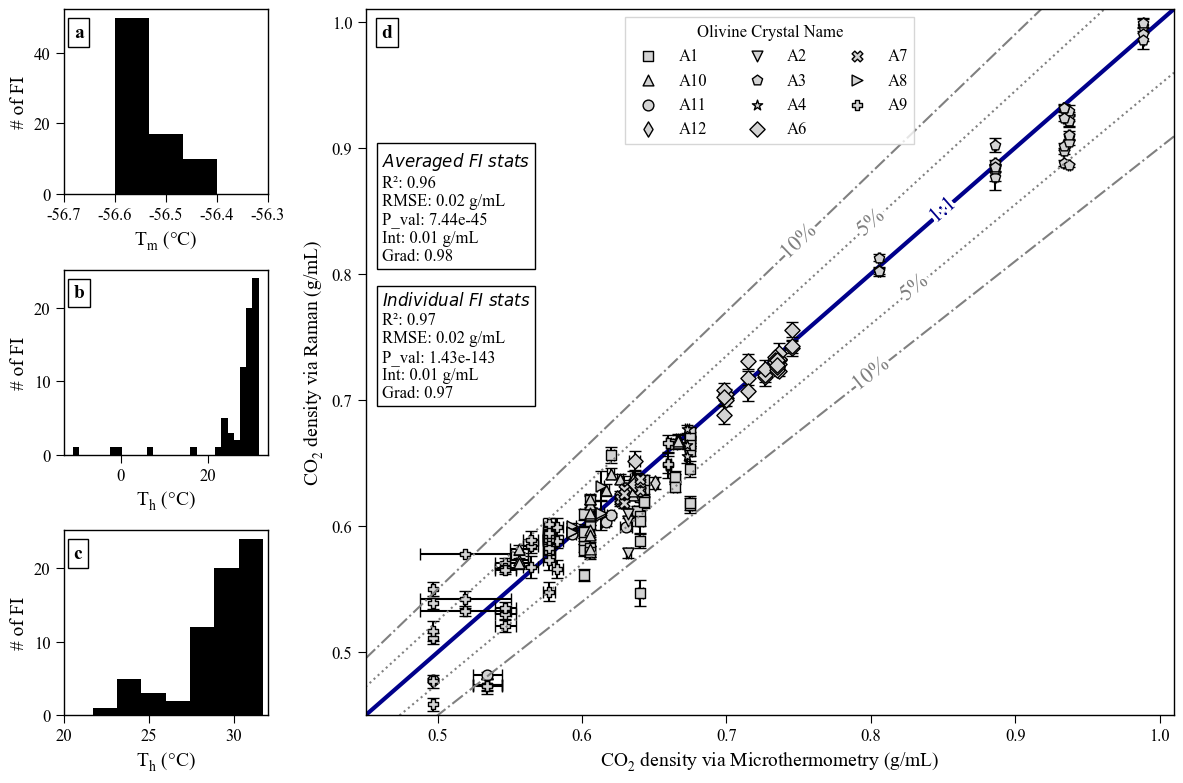

In [8]:
figure_mosaic="""
ADDD
BDDD
CDDD
"""
fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(12, 8))
# xlim=[0,1.5]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

axes['A'].axes.get_xaxis().set_visible(True)
axes['B'].axes.get_xaxis().set_visible(True)
axes['C'].axes.get_xaxis().set_visible(True)
axes['D'].axes.get_xaxis().set_visible(True)


## Microtherm ##
# Panel 'a'
axes['A'].hist(averaged_df['Corrected Melting temperature Tm (˚C)'], bins=3, color='black')
axes['A'].set_xticks([x / 10 for x in range(-567, -562)])
axes['A'].set_xticklabels([f'{x / 10:.1f}' for x in range(-567, -562)])
axes['A'].set_xlabel('$T_{m}$ (°C)')
axes['A'].set_ylabel('# of FI')
axes['A'].text(0.05, 0.85, 'a', transform=axes['A'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)


# Panel 'b'
axes['B'].hist(averaged_df[['Corrected Upper bound Th (˚C)', 'Corrected Lower bound Th (˚C)']].mean(axis=1), bins=30, color='black')
axes['B'].set_xlabel('$T_{h}$ (°C)')
axes['B'].set_ylabel('# of FI')
axes['B'].text(0.05, 0.85, 'b', transform=axes['B'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)


# Panel 'c'
axes['C'].hist(averaged_df[['Corrected Upper bound Th (˚C)', 'Corrected Lower bound Th (˚C)']].mean(axis=1), bins=30, color='black')
axes['C'].set_xlabel('$T_{h}$ (°C)')
axes['C'].set_ylabel('# of FI')
axes['C'].text(0.05, 0.85, 'c', transform=axes['C'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)
axes['C'].set_xlim([20,32])

# # Panel 'c' as density
# axes['C'].hist(averaged_df['Fluid inclusion mean bulk CO2 density (g/cm3)'], bins=15, color='black')
# axes['C'].set_xlabel('$CO _{2}$ density (g/mL)')
# axes['C'].set_ylabel('# of FI')
# axes['C'].text(0.05, 0.85, 'c', transform=axes['C'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)

## Comparison
# Panel 'd'

df_4plot=totaldf.copy()


y = 'CO2 density (g/cm3)'#'ν1_Combofit_height (a.u.)'#'Splitting'#'Raman-microT'#'CO2_dens_gcm3_input'
x = 'Fluid inclusion mean bulk CO2 density (g/cm3)'#'Fluid inclusion mean bulk CO2 density (g/cm3)'

xerr='Fluid inclusion mean bulk CO2 density (g/cm3) _std dev'
yerr='CO2 density 1σ from DiadFit (g/cm3)'
color_column = 'ν1_Combofit_height (a.u.)'#yerr#'Split_err_quadrature'

#df = averaged_df.dropna(subset=[x, y, color_column])
df=df_4plot.dropna(subset=[x,y,yerr])

grouped = df.groupby('Host crystal ID')
symbols = ['s', '^', 'o', 'd', 'v', 'p', '*', 'D', 'X', '>', 'P','<']

for i, (name, group) in enumerate(grouped):
    symbol = symbols[i % len(symbols)]
    if type(yerr) == str:
        yerr_in = group[yerr]
    else:
        yerr_in = 0
    if type(xerr) == str:
        xerr_in = group[xerr]
    else:
        xerr_in = 0
    label = f"Xtal {name}"  # Add a label for each group
    color='lightgrey'#group[color_column][filter]

    if name == "A1":
        axes['D'].errorbar(x=group[x], y=group[y],xerr=xerr_in, yerr=yerr_in, marker='', linestyle='', zorder=-1,ecolor='k',barsabove=False,capsize=4)
        sc = axes['D'].scatter(group[x], group[y], label=name, marker=symbol,s=60, c=color, edgecolor='k',cmap=None,zorder=0,alpha=1)
    else:
        axes['D'].errorbar(x=group[x], y=group[y],xerr=xerr_in, yerr=yerr_in, marker='', linestyle='', zorder=-1,ecolor='k',barsabove=False,capsize=4)
        sc = axes['D'].scatter(group[x], group[y], marker=symbol,s=60, c=color, label=name,edgecolor='k',cmap=None,zorder=0,alpha=1)


# axes['D'].errorbar(x=averaged_df[x], y=averaged_df[y],xerr=averaged_df[xerr],yerr=averaged_df['rho_err'],marker='s', linestyle='',capsize=4,zorder=-2,color='grey',label='Individual FI measurements')

xlim=(0.45,1.01)

axes['D'].text(0.02, 0.96, 'd', transform=axes['D'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)
axes['D'].legend(loc='upper center',ncols=3,title='Olivine Crystal Name')

axes['D'].set_xlabel('$CO _{2}$ density via Microthermometry (g/mL)')
axes['D'].set_ylabel('$CO _{2}$ density via Raman (g/mL)')
axes['D'].set_xlim([xlim[0],xlim[1]])
axes['D'].set_ylim(xlim[0],xlim[1])

axes['D'].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]],'darkblue',zorder=-3,linewidth=3,label="1:1")
axes['D'].plot([xlim[0],xlim[1]],[xlim[0]+0.1*xlim[0],xlim[1]+0.1*xlim[1]],'grey',linestyle='-.',label="10%")
axes['D'].plot([xlim[0],xlim[1]],[xlim[0]-0.1*xlim[0],xlim[1]-0.1*xlim[1]],'grey',linestyle='-.',label="10%")
axes['D'].plot([xlim[0],xlim[1]],[xlim[0]+0.05*xlim[0],xlim[1]+0.05*xlim[1]],'grey',linestyle=':',label="5%")
axes['D'].plot([xlim[0],xlim[1]],[xlim[0]-0.05*xlim[0],xlim[1]-0.05*xlim[1]],'grey',linestyle=':',label="5%")
labelLines(axes['D'].get_lines(), zorder=2.5,xvals=[0.85,0.75,0.8,0.8,0.83],fontsize=16)

### Averaged FI regression
pval_format=None
round_num=2

linereg_averagedFI = calculate_R2(averaged_df[x], averaged_df[y],xy=False,round=round_num, pval_format=pval_format)

keys_to_extract = ['R²', 'RMSE', 'P_val', 'Int', 'Grad']
linereg_averagedFI = {key: linereg_averagedFI[key] for key in keys_to_extract}
if pval_format != 'decimal':
    linereg_averagedFI['P_val'] = '{:.{}e}'.format(float(linereg_averagedFI['P_val']), round_num)

linereg_info_averagedFI = "\n".join(
    f"{key}: {value}" + (" g/mL" if key in {'RMSE', 'MAE', 'Median', 'Mean', 'Int'} else "")
    for key, value in list(linereg_averagedFI.items())
)

### Individual FI regression

linereg_indFI = calculate_R2(totaldf[x], totaldf[y],xy=False,round=round_num, pval_format=pval_format)
linereg_indFI = {key: linereg_indFI[key] for key in keys_to_extract}

if pval_format != 'decimal':
    linereg_indFI['P_val'] = '{:.{}e}'.format(float(linereg_indFI['P_val']), round_num)

linereg_info_indFI = "\n".join(
    f"{key}: {value}" + (" g/mL" if key in {'RMSE', 'MAE', 'Median', 'Mean', 'Int'} else "")
    for key, value in list(linereg_indFI.items())
    )

# This adds text boxes with the regression information
averagedFI_text = r'$\mathit{Averaged\ FI\ stats}$' + '\n' + linereg_info_averagedFI
indFI_text = r'$\mathit{Individual\ FI\ stats}$' + '\n' + linereg_info_indFI

linereg_box_averagedFI = axes['D'].text(0.02, 0.8, averagedFI_text, transform=axes['D'].transAxes,
                                        fontsize=12, bbox=bbox, verticalalignment='top')

linereg_box_indFI = axes['D'].text(0.02, 0.6, indFI_text, transform=axes['D'].transAxes,
                             fontsize=12, bbox=bbox, verticalalignment='top')
## Save figure
fig.tight_layout()
fig.savefig(figpath+'/'+'FigS4_microthermvsRaman.pdf')
fig.savefig(figpath+'/'+'FigS4_microthermvsRaman.png',dpi=300)

## FIGURE 2 

### Import the data

In [9]:
## Get the FI data
lei_df=pd.read_excel("DATASET_S-1_revised_final.xlsx", sheet_name='Table S-1 Kilauea FI',skiprows=2) ## This one was filtered for fluid>80% and bad spec out

lei_df['Sample_ID'] = lei_df['Event ID (LL8 - July, LL7-Aug, LL4-May)']
lei_df['CO2_dens_gcm3_std']=lei_df['CO2 density standard deviation of repeats (g/cm3)']

## Get the melt inclusion data
mis=pd.read_excel("DATASET_S-1_revised_final.xlsx", sheet_name='Wieseretal2021_sup')

mis.insert(0,'Sample_ID', np.nan)
mis['Sample_ID'] = mis['Sample Name'].apply(lambda x: next((s for s in ['LL8', 'LL7', 'LL4'] if s in x), None))

display(lei_df.head())
display(mis.head())

,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,"Magmasat Saturation Pressure (Glass only, PEC corrected)",Magmasat Saturation Pressure (mean bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (max bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (min bubble CO2 from EOS+Glass CO2; PEC corrected),"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble),Sample_ID,CO2_dens_gcm3_std
0,0,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#1,"ν1 refers to the low wavenumber band of the fermi diad of CO2, 2ν2 refers to the highwavenumber band. ""Combofit"" parameters are those used to calculate corrected fermi diad separation and co2 densities.",103.416763,103.186144,0.006461,0.176605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4,0.001314
1,1,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#2,NaN,103.431244,103.195894,0.007137,0.180578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4,NaN
2,2,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-MI#1,NaN,103.429713,103.196578,0.010404,0.180858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4,0.004029
3,3,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-#2,NaN,103.379425,103.122405,0.001766,0.147317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4,0.001696
4,7,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-MI#5,NaN,103.170121,102.953345,0.007431,0.080378,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LL4,NaN


,Sample_ID,Description,Sample Name,"Specific ID (LL8 - lab code for F8 Mid July, LL7- lab code for Aug 1st, LL4- lab code for May 30th)","Classification (1=bubble with fermi diad, 2=No bubble, 3=bubble but no fermi diad)",Cracked (for ones without diads),"Na2O (wt%, measured)","Al2O3 (wt%, measured)","P2O5 (wt%, measured)","CaO (wt%, measured)",...,"Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Magmasat Saturation Pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigma bubble vol))","Magmasat Saturation Pressure (Glass only, PEC corrected)",Magmasat Saturation Pressure (mean bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (max bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (min bubble CO2 from EOS+Glass CO2; PEC corrected),"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble)
0,LL8,1,LL8_613b,Fissure 8 (Mid July),1,NaN,2.8528,14.9080,0.2649,12.2542,...,440,200,70,460,610,280,519.017638,240.244165,61.217817,543.710679
1,LL8,2,LL8_615,Fissure 8 (Mid July),1,NaN,2.8114,14.4189,0.3026,12.2457,...,610,190,70,650,870,370,723.216448,228.749112,59.699491,764.009145
2,LL8,3,LL8_617_a,Fissure 8 (Mid July),1,NaN,2.7212,14.7306,0.3789,12.4949,...,600,270,80,680,910,390,690.876996,316.357286,63.990493,774.046353
3,LL8,4,LL8_623_b,Fissure 8 (Mid July),1,NaN,2.6459,14.9646,0.3763,12.4287,...,1550,450,70,540,710,310,1596.815651,516.027112,40.961717,609.609418
4,LL8,5,LL8_626,Fissure 8 (Mid July),1,NaN,2.7685,14.7415,0.2647,12.2405,...,1080,260,50,170,220,110,1183.193159,303.234906,11.958965,195.618260


## Figure 2 - Main paper

In [10]:
## Create a sub frame with pairs of melt-no melt 
melt_nomelt_pairs=lei_df[(lei_df['Melt-Nomelt pair']=='Yes')].copy()#&(lei_df['ν1_Combofit_height (a.u.)']>50)]&~(lei_df['CO2 density 1σ (g/cm3)']>0.03)
melt_nomelt_pairs['CO2_err(stdev or 1sig)']=melt_nomelt_pairs['CO2_dens_gcm3_std'].fillna(melt_nomelt_pairs['CO2 density 1σ (g/cm3)'])

## Setup variables for plotting

MI_P_var = 'Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'
MI_P_err_var = 'Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)'

mifi_only = lei_df[~lei_df[MI_P_var].isna()].copy()
mifi_only['CO2_err(stdev or 1sig)']=mifi_only['CO2_dens_gcm3_std'].fillna(mifi_only['CO2 density 1σ (g/cm3)'])
mifi_only.loc[:, 'Sat_P_MI_kbar'] = mifi_only[MI_P_var] / 1000
mifi_only.loc[:, 'Sat_P_MI_kbar_err'] = (mifi_only[MI_P_err_var] / 1000) - mifi_only[MI_P_var] / 1000

mifi_only.head()


,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,Magmasat Saturation Pressure (min bubble CO2 from EOS+Glass CO2; PEC corrected),"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble),Sample_ID,CO2_dens_gcm3_std,CO2_err(stdev or 1sig),Sat_P_MI_kbar,Sat_P_MI_kbar_err
42,57,"LERZ, Fissure 8, May 30th 2018",LL4,LL4_12,LL4_12-FI#1,NaN,103.229512,102.986690,0.004517,0.093581,...,630.0,1570.739858,501.311982,75.206964,1251.200106,LL4,NaN,0.001789,0.91,0.57
43,58,"LERZ, Fissure 8, May 30th 2018",LL4,LL4_12,LL4_12-FI#2,NaN,103.230873,102.987661,0.004232,0.093965,...,630.0,1570.739858,501.311982,75.206964,1251.200106,LL4,NaN,0.001676,0.91,0.57
44,59,"LERZ, Fissure 8, May 30th 2018",LL4,LL4_12,LL4_12-MI#2,NaN,103.181124,102.938845,0.006239,0.074636,...,630.0,1570.739858,501.311982,75.206964,1251.200106,LL4,NaN,0.002470,0.91,0.57
45,60,"LERZ, Fissure 8, May 30th 2018",LL4,LL4_2,LL4_2-FI#1,NaN,103.317645,103.071739,0.006413,0.127256,...,680.0,1448.103735,521.199080,151.280097,1525.638030,LL4,NaN,0.002539,0.72,0.42
46,61,"LERZ, Fissure 8, May 30th 2018",LL4,LL4_2,LL4_2-FI#2,NaN,103.371192,103.134190,0.006748,0.151983,...,680.0,1448.103735,521.199080,151.280097,1525.638030,LL4,NaN,0.002672,0.72,0.42


### Now plot Fig 2

c:\Users\charl\anaconda3\envs\pydev\Lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_nolegend_), but could not find a label for it.
  warnings.warn(
C:\Users\charl\AppData\Local\Temp\ipykernel_25784\134233294.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()
c:\Users\charl\anaconda3\envs\pydev\Lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_nolegend_), but could not find a label for it.
  warnings.warn(


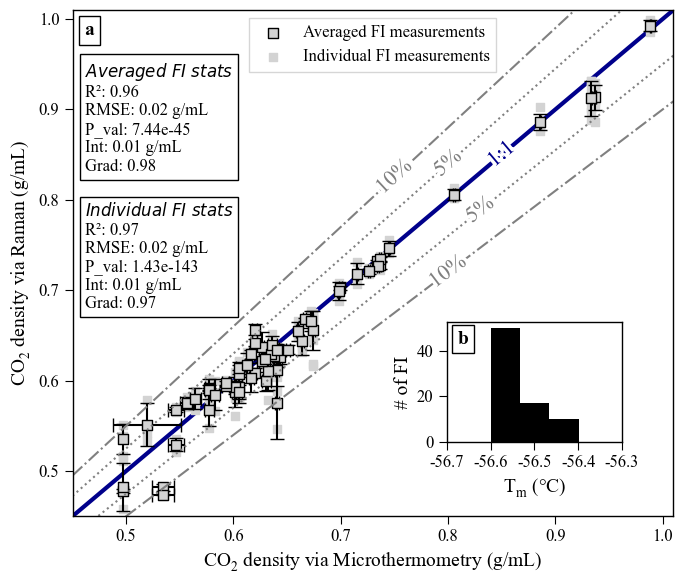

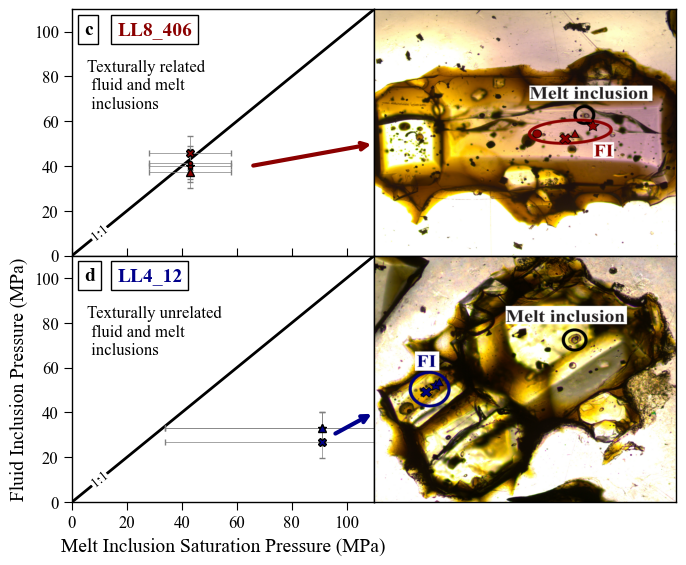

In [11]:
import re

figure_mosaic="""
A

"""
fig1,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(7, 6))
# xlim=[0,1.5]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')


## Comparison
# Panel 'd'

df_4plot=averaged_df.copy()
# splitnames = df_4plot['filename_stripped'].str.split('-')

# xtal=pd.Series(index=splitnames.index,dtype='float64')

# for row in splitnames.index:
#     for spot in splitnames[row]:
#         if 'A' in spot:
#             xtal[row]=spot

# df_4plot['Host crystal ID'] = xtal

y = 'CO2 density (g/cm3)'#'ν1_Combofit_height (a.u.)'#'Splitting'#'Raman-microT'#'CO2_dens_gcm3_input'
x = 'Fluid inclusion mean bulk CO2 density (g/cm3)'#'Fluid inclusion mean bulk CO2 density (g/cm3)'

xerr='Fluid inclusion mean bulk CO2 density (g/cm3) _std dev'
yerr='CO2 density error (stdev repeats or 1σ DiadFit; g/cm3)'#'rho_err'
color_column = 'ν1_Combofit_height (a.u.)'#yerr#'Split_err_quadrature'

#df = averaged_df.dropna(subset=[x, y, color_column])
df=df_4plot.dropna(subset=[x,y,yerr])

grouped = df.groupby('Host crystal ID')
symbols = ['s']

for i, (name, group) in enumerate(grouped):
    symbol = symbols[i % len(symbols)]
    if type(yerr) == str:
        yerr_in = group[yerr]
    else:
        yerr_in = 0
    if type(xerr) == str:
        xerr_in = group[xerr]
    else:
        xerr_in = 0
    label = f"Xtal {name}"  # Add a label for each group
    color='lightgrey'#group[color_column][filter]

    if name == "A1":
        axes['A'].errorbar(x=group[x], y=group[y],xerr=xerr_in, yerr=yerr_in, marker='', linestyle='', zorder=-1,ecolor='k',barsabove=False,capsize=5)
        sc = axes['A'].scatter(group[x], group[y], label="Averaged FI measurements", marker=symbol,s=60, c=color, edgecolor='k',cmap=None,zorder=0,alpha=1)
    else:
        axes['A'].errorbar(x=group[x], y=group[y],xerr=xerr_in, yerr=yerr_in, marker='', linestyle='', zorder=-1,ecolor='k',barsabove=False,capsize=5)
        sc = axes['A'].scatter(group[x], group[y], marker=symbol,s=60, c=color, edgecolor='k',cmap=None,zorder=0,alpha=1)


axes['A'].scatter(x=totaldf[x], y=totaldf[y],marker='s', zorder=-2,color='lightgrey',label='Individual FI measurements')

xlim=(0.45,1.01)

axes['A'].text(0.02, 0.95, 'a', transform=axes['A'].transAxes, fontsize=14, fontweight='bold',bbox=bbox)
axes['A'].legend(loc='upper center')

axes['A'].set_xlabel('$CO _{2}$ density via Microthermometry (g/mL)')
axes['A'].set_ylabel('$CO _{2}$ density via Raman (g/mL)')
axes['A'].set_xlim([xlim[0],xlim[1]])
axes['A'].set_ylim(xlim[0],xlim[1])

axes['A'].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]],'darkblue',zorder=-3,linewidth=3,label="1:1")
axes['A'].plot([xlim[0],xlim[1]],[xlim[0]+0.1*xlim[0],xlim[1]+0.1*xlim[1]],'grey',linestyle='-.',label="10%")
axes['A'].plot([xlim[0],xlim[1]],[xlim[0]-0.1*xlim[0],xlim[1]-0.1*xlim[1]],'grey',linestyle='-.',label="10%")
axes['A'].plot([xlim[0],xlim[1]],[xlim[0]+0.05*xlim[0],xlim[1]+0.05*xlim[1]],'grey',linestyle=':',label="5%")
axes['A'].plot([xlim[0],xlim[1]],[xlim[0]-0.05*xlim[0],xlim[1]-0.05*xlim[1]],'grey',linestyle=':',label="5%")
labelLines(axes['A'].get_lines(), zorder=2.5,xvals=[0.85,0.75,0.8,0.8,0.83],fontsize=16)

## Create inset subplot
inset_width = 0.25
inset_height = 0.2
inset_left = 0.65
inset_bottom = 0.25

inset_ax = fig1.add_axes([inset_left, inset_bottom, inset_width, inset_height])

inset_ax.hist(averaged_df['Corrected Melting temperature Tm (˚C)'], bins=3, color='black')
inset_ax.set_xlabel('$T_{m}$ (°C)')
inset_ax.set_ylabel('# of FI')
inset_ax.set_xticks([x / 10 for x in range(-567, -562)])
inset_ax.set_xticklabels([f'{x / 10:.1f}' for x in range(-567, -562)])
inset_ax.text(0.06, 0.82, 'b', transform=inset_ax.transAxes, fontsize=14, fontweight='bold',bbox=bbox)


### Averaged FI regression
pval_format=None
round_num=2

linereg_averagedFI = calculate_R2(averaged_df[x], averaged_df[y],xy=False,round=round_num, pval_format=pval_format)

keys_to_extract = ['R²', 'RMSE', 'P_val', 'Int', 'Grad']
linereg_averagedFI = {key: linereg_averagedFI[key] for key in keys_to_extract}
if pval_format != 'decimal':
    linereg_averagedFI['P_val'] = '{:.{}e}'.format(float(linereg_averagedFI['P_val']), round_num)

linereg_info_averagedFI = "\n".join(
    f"{key}: {value}" + (" g/mL" if key in {'RMSE', 'MAE', 'Median', 'Mean', 'Int'} else "")
    for key, value in list(linereg_averagedFI.items())
)

### Individual FI regression

linereg_indFI = calculate_R2(totaldf[x], totaldf[y],xy=False,round=round_num, pval_format=pval_format)
linereg_indFI = {key: linereg_indFI[key] for key in keys_to_extract}

if pval_format != 'decimal':
    linereg_indFI['P_val'] = '{:.{}e}'.format(float(linereg_indFI['P_val']), round_num)

linereg_info_indFI = "\n".join(
    f"{key}: {value}" + (" g/mL" if key in {'RMSE', 'MAE', 'Median', 'Mean', 'Int'} else "")
    for key, value in list(linereg_indFI.items())
    )

# This adds text boxes with the regression information
averagedFI_text = r'$\mathit{Averaged\ FI\ stats}$' + '\n' + linereg_info_averagedFI
indFI_text = r'$\mathit{Individual\ FI\ stats}$' + '\n' + linereg_info_indFI

linereg_box_averagedFI = axes['A'].text(0.02, 0.90, averagedFI_text, transform=axes['A'].transAxes,
                                        fontsize=12, bbox=bbox, verticalalignment='top')

linereg_box_indFI = axes['A'].text(0.02, 0.62, indFI_text, transform=axes['A'].transAxes,
                             fontsize=12, bbox=bbox, verticalalignment='top')

## Saves figure
fig1.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

fig1.savefig(figpath+'/'+'Fig1_microthermvsRaman.pdf')
fig1.savefig(figpath+'/'+'Fig1_microthermvsRaman.png')

###################################################################################
###################################################################################



figure_mosaic="""
CG
DK


"""

plot_var = 'Host crystal ID'
name_var = 'Fluid inclusion ID'
color_column='SO2_CO2_AreaRatio'


fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(7.8, 6.4))
xlim=[0,110]
ylim=[0,110]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

x='Sat_P_MI_kbar'
y='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (MPa)'

xerr = 'Sat_P_MI_kbar_err'
yerr = 'Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (MPa)'

text_related=mifi_only['Texturally Related/Unrelated']=='R'
text_unrelated=mifi_only['Texturally Related/Unrelated']!='R'
textrelated_example='LL8_406'
textunrelated_example='LL4_12'


filter_labels = [textrelated_example, textunrelated_example]

filters = [
    (mifi_only[plot_var].str.contains(label), label) for label in filter_labels
]

symbols = ['*', '^', 'X', '.', 's', 'p', 'K', 'd']

for ax_key, (filt, label) in zip(['C', 'D'], filters):
    ax = axes[ax_key]
    
    mask = filt  # Use the current filter to create a mask
    
    unique_names = mifi_only[mask][name_var].unique()
    num_names = len(unique_names)
    
    # Determine the color based on ax_key
    point_color = 'darkred' if ax_key == 'C' else 'darkblue'
    
    for idx, name in enumerate(unique_names):
        select_name = name
        xtal_title = re.split(r'[-_]', name)[0] + '_' + re.split(r'[-_]', name)[1]
        name_mask = mifi_only[mask][name_var] == select_name
        
        # Get the symbol for the current name
        symbol = symbols[idx % len(symbols)]
        
        for sample in mifi_only[mask][name_mask][plot_var].unique():
            sample_mask = mifi_only[mask][name_mask][plot_var] == sample
            x_coord = mifi_only[mask][name_mask][sample_mask].loc[:, 'Sat_P_MI_kbar']
            y_coord = mifi_only[mask][name_mask][sample_mask].loc[:, 'Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (MPa)']
            
            # Plot points using the chosen symbol and color
            ax.errorbar(x_coord*100, y_coord, xerr=mifi_only[mask][name_mask][sample_mask][xerr]*100,
                        yerr=mifi_only[mask][name_mask][sample_mask][yerr],
                        fmt=symbol, linestyle='none', label=re.split(r'[-_]', name)[-1],
                        ecolor='grey', elinewidth=0.5, capsize=2, zorder=-2,
                        color=point_color, mec='k')
            
        # ax.legend(loc='upper right', fontsize=12, ncols=1) #title=xtal_title,



for ax_key in [ 'C', 'D']:
    ax = axes[ax_key]

    ax.set_xlabel('Melt Inclusion Saturation Pressure (MPa)')
    ax.set_ylabel('Fluid Inclusion Pressure (MPa)')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k', zorder=-3, linewidth=2, label="1:1")

    xvals = [10]  # Define x-values for labelLines if needed
    labelLines(ax.get_lines(), zorder=2.5, xvals=xvals, fontsize=10)




subplot_labels = ['C','D']
pos_a2h=(0.04, 0.9)#(0.92,0.1)#
label_positions = [pos_a2h, pos_a2h, pos_a2h, pos_a2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)


# Load the images for axes a-d
extension=".tif"
image_f = plt.imread(helper_file_folder+'/'+"LL8_406_5X_mod"+extension)
image_g = plt.imread(helper_file_folder+'/'+"LL4_12_5X_mod"+extension)

axis_labels = ['G', 'K']
axes['G'].imshow(image_f,aspect='auto')
axes['K'].imshow(image_g,aspect='auto')


axes['C'].text(0.15,0.9,textrelated_example,transform=axes['C'].transAxes,fontsize=14,fontweight='bold',color='darkred',bbox=bbox)
axes['D'].text(0.15,0.9,textunrelated_example,transform=axes['D'].transAxes,fontsize=14,fontweight='bold',color='darkblue',bbox=bbox)

axes['C'].text(0.05,0.6,'Texturally related \n fluid and melt \n inclusions',transform=axes['C'].transAxes,fontsize=12)
axes['D'].text(0.05,0.6,'Texturally unrelated \n fluid and melt \n inclusions',transform=axes['D'].transAxes,fontsize=12)


axes['C'].tick_params(axis='x', direction='in')
axes['C'].set_xticklabels([])
axes['C'].set_xlabel('')
axes['C'].set_ylabel('')

for label in axis_labels:
    axes[label].axis('on')
    axes[label].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])


arrow_start = (65, 40)
arrow_end = (110,50)
arrow_properties = dict(arrowstyle='<-', lw=3, color='darkred')

axes['C'].annotate('',
              xy=arrow_start,
              xytext=arrow_end,
              arrowprops=arrow_properties)

arrow_start = (95, 30)
arrow_end = (110,40)
arrow_properties = dict(arrowstyle='<-', lw=3, color='darkblue')

axes['D'].annotate('',
              xy=arrow_start,
              xytext=arrow_end,
              arrowprops=arrow_properties)



## Saves figure
plt.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()
fig.savefig(figpath+'/'+'Fig2_rev_pt1.pdf', dpi=300)
fig1.savefig(figpath+'/'+'Fig2_rev_pt2.pdf', dpi=300)


## Fig for supplement? Maybe. Has all the spots 

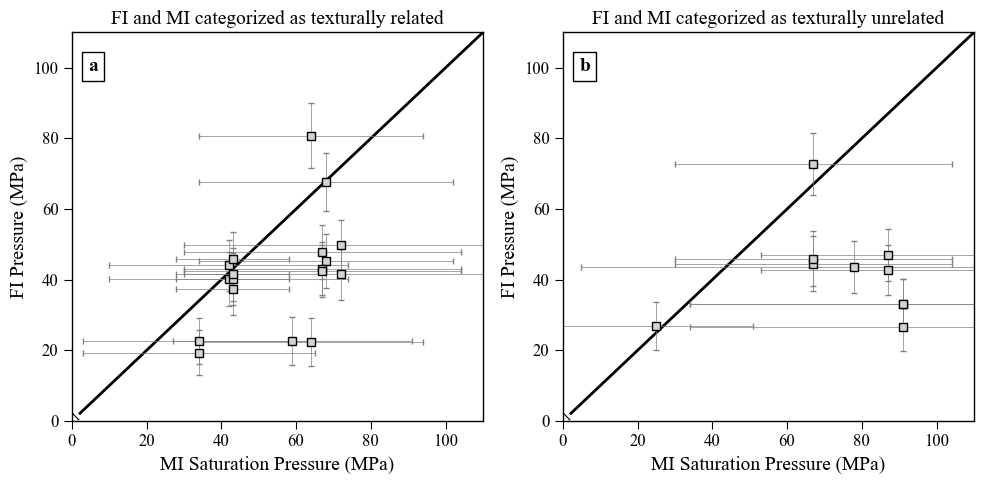

In [47]:
figure_mosaic="""
AB


"""

plot_var = 'Host crystal ID'
name_var = 'Fluid inclusion ID'
color_column='SO2_CO2_AreaRatio'


fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(10, 5))
xlim=[0,110]
ylim=[0,110]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

x='Sat_P_MI_kbar'
y='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (MPa)'

xerr = 'Sat_P_MI_kbar_err'
yerr = 'Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (MPa)'

text_related=mifi_only['Texturally Related/Unrelated']=='R'
text_unrelated=mifi_only['Texturally Related/Unrelated']!='R'
textrelated_example='LL8_406'
textunrelated_example='LL4_12'

axes['A'].errorbar(mifi_only[x][text_related]*100, mifi_only[y][text_related], xerr=mifi_only[xerr][text_related]*100, yerr=mifi_only[yerr][text_related],
            fmt='s', linestyle='none', label='Other texturally related',ecolor='grey', elinewidth=0.5, capsize=2,
            zorder=-2, color='lightgrey',mec='k')

specific_FI=(text_related)&(mifi_only[name_var].str.contains(textrelated_example))

# axes['A'].errorbar(mifi_only[x][specific_FI]*100, mifi_only[y][specific_FI], xerr=mifi_only[xerr][specific_FI]*100, yerr=mifi_only[yerr][specific_FI],
#             fmt='s', linestyle='none', label=textrelated_example, ecolor='grey', elinewidth=0.5, capsize=2,
#             zorder=-2, color='darkred',mec='k')

# axes['A'].legend(loc='upper right',fontsize=12)#,title='Texturally related'

axes['B'].errorbar(mifi_only[x][text_unrelated]*100, mifi_only[y][text_unrelated], xerr=mifi_only[xerr][text_unrelated]*100, yerr=mifi_only[yerr][text_unrelated],
            fmt='s', linestyle='none', label='Other texturally unrelated',ecolor='grey', elinewidth=0.5, capsize=2,
            zorder=-2, color='lightgrey',mec='k')

specific_FI=(text_unrelated)&(mifi_only[name_var].str.contains(textunrelated_example))

# axes['B'].errorbar(mifi_only[x][specific_FI]*100, mifi_only[y][specific_FI], xerr=mifi_only[xerr][specific_FI]*100, yerr=mifi_only[yerr][specific_FI],
#             fmt='s', linestyle='none', label=textunrelated_example, ecolor='grey', elinewidth=0.5, capsize=2,
#             zorder=-2, color='darkblue',mec='k')
# axes['B'].legend(loc='upper right',fontsize=12)#,title='Texturally unrelated'
axes['A'].set_title("FI and MI categorized as texturally related")
axes['B'].set_title("FI and MI categorized as texturally unrelated")

for ax_key in ['A', 'B']:
    ax = axes[ax_key]

    ax.set_xlabel('MI Saturation Pressure (MPa)')
    ax.set_ylabel('FI Pressure (MPa)')

    if ax_key in ['A','B']:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k', zorder=-3, linewidth=2, label="1:1")

    xvals = [0.1]  # Define x-values for labelLines if needed
    labelLines(ax.get_lines(), zorder=2.5, xvals=xvals, fontsize=10)


subplot_labels = ['A', 'B']
pos_a2h=(0.04, 0.9)#(0.92,0.1)#
label_positions = [pos_a2h, pos_a2h, pos_a2h, pos_a2h, 
                   pos_a2h, pos_a2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)

## Saves figure
fig.tight_layout()
fig.savefig(figpath+'/'+'FigS_AllMIFIpairs.pdf', dpi=300)
fig.savefig(figpath+'/'+'FigS_AllMIFIpairs.png', dpi=300)



### FIGS12 (texture for supplement)

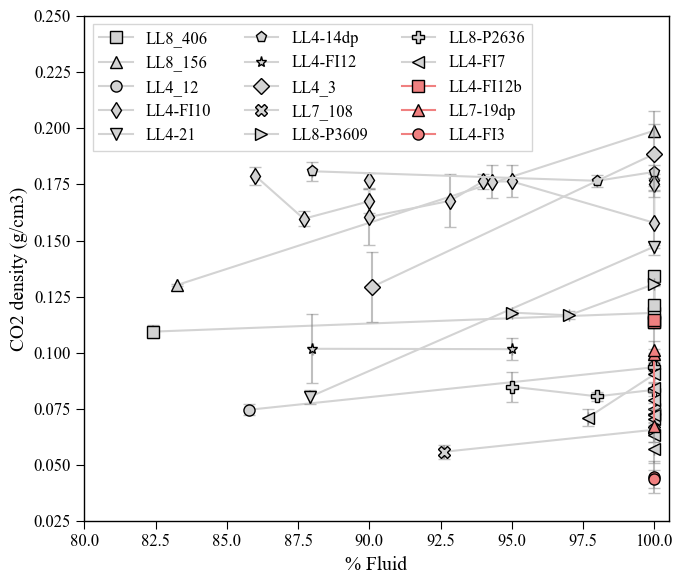

In [13]:
figure_mosaic="""
I
"""

plot_var = 'Host crystal ID'
name_var = 'Fluid inclusion ID'
color_column='SO2_CO2_AreaRatio'


fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(7, 6))
xlim=[80,100.5]
ylim=[0.025,0.25]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

## Plot 'I'


x = '% Fluid'
y = 'CO2 density (g/cm3)'

xerr = 'CO2 density 1σ (g/cm3)'  # 'CO2_err(stdev or 1sig)'
yerr = 'CO2 density 1σ (g/cm3)'  # 'CO2_err(stdev or 1sig)'
color = 'lightgrey'
colors = ['lightgrey', 'lightcoral']  # List of colors to cycle through

df_4plot=melt_nomelt_pairs.copy()
df_4plot=df_4plot.sort_values(by=x)
symbols = ['s', '^', 'o', 'd', 'v', 'p', '*', 'D', 'X', '>', 'P', '<']

# Create a list of unique values in the 'Host crystal ID' column
xtal_values = df_4plot['Host crystal ID'].unique()

# Initialize counters to keep track of the symbol and color indices
symbol_index = 0
color_index = 0

for i, xtal_value in enumerate(xtal_values):
    xtal_df = df_4plot[df_4plot['Host crystal ID'] == xtal_value]
    
    # Skip groups with only one entry
    if len(xtal_df) <= 1:
        continue
    
    symbol = symbols[symbol_index % len(symbols)]  # Cycle through symbols
    color = colors[color_index % len(colors)]  # Cycle through colors
    # axes['A'].plot(x_group, y_group, marker='', linestyle='-', zorder=-1,color='black')
        
    axes['I'].errorbar(x=xtal_df[x], y=xtal_df[y], xerr=xtal_df[xerr], yerr=xtal_df[yerr],
                       marker='', linestyle="",ecolor='grey', barsabove=False, capsize=4, alpha=0.5)

    sc=axes['I'].plot(xtal_df[x], xtal_df[y], mec='k', mfc=color,marker=symbol, markersize=8, linestyle='-', color=color, label=xtal_value)


    # Update the symbol index and color index
    symbol_index += 1
    if symbol_index % len(symbols) == 0 and symbol_index != 0:
        color_index += 1

axes['I'].legend(ncol=3, loc='best',fontsize=12)
axes['I'].set_xlabel('% Fluid')
axes['I'].set_ylabel('CO2 density (g/cm3)')
axes['I'].set_xlim(xlim)
axes['I'].set_ylim(ylim)

## Saves figure
fig.tight_layout()
fig.savefig(figpath+'/'+'FigS12_Fluid_percent_pairs.pdf')
fig.savefig(figpath+'/'+'FigS12_Fluid_percent_pairs.png')

### FIGS13 textures for supplement (This is each individual plot)

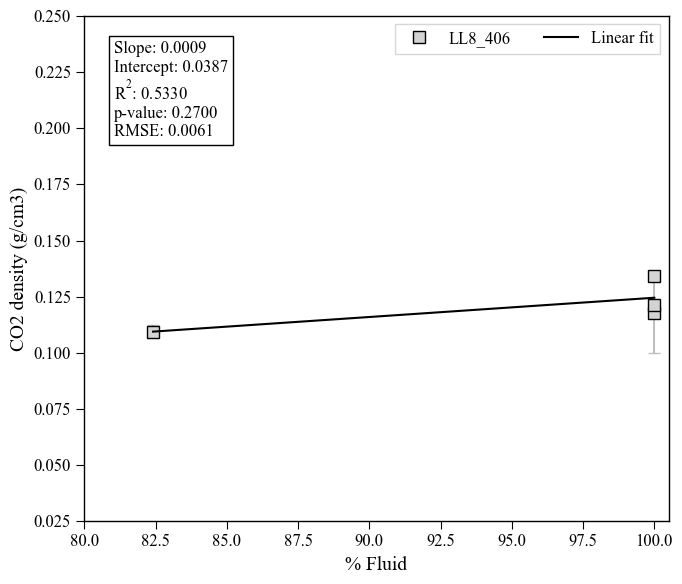

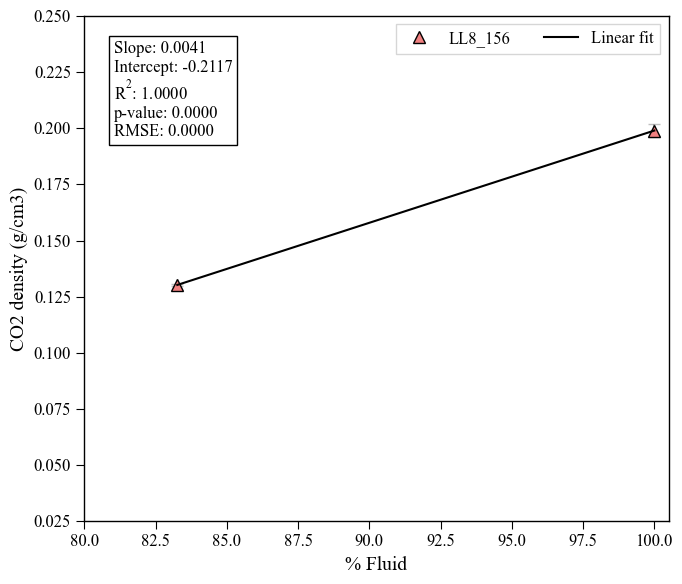

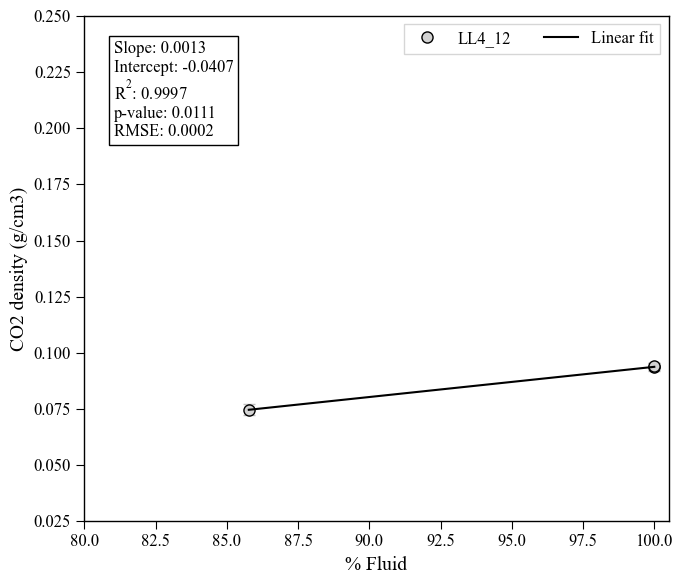

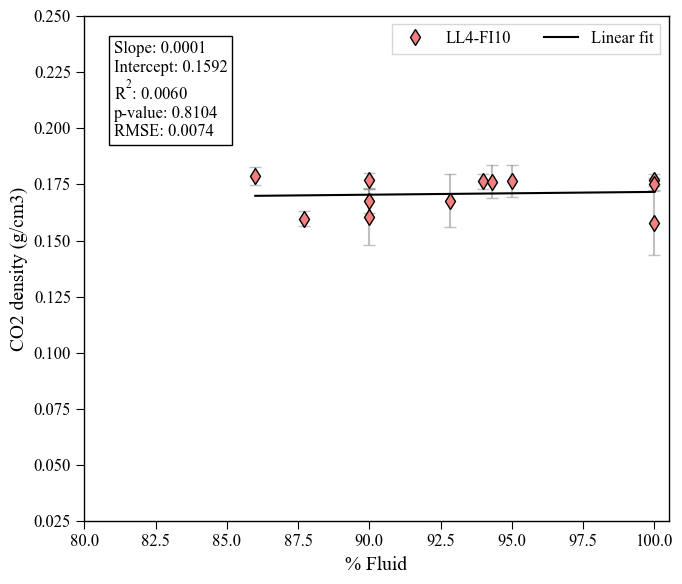

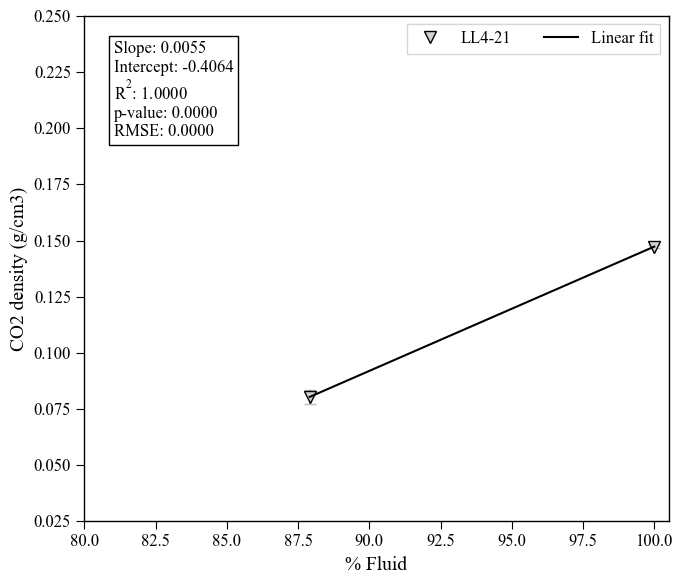

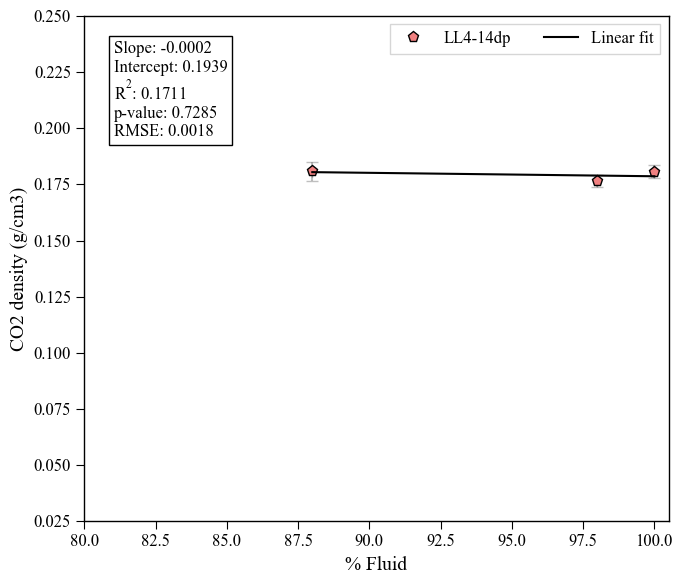

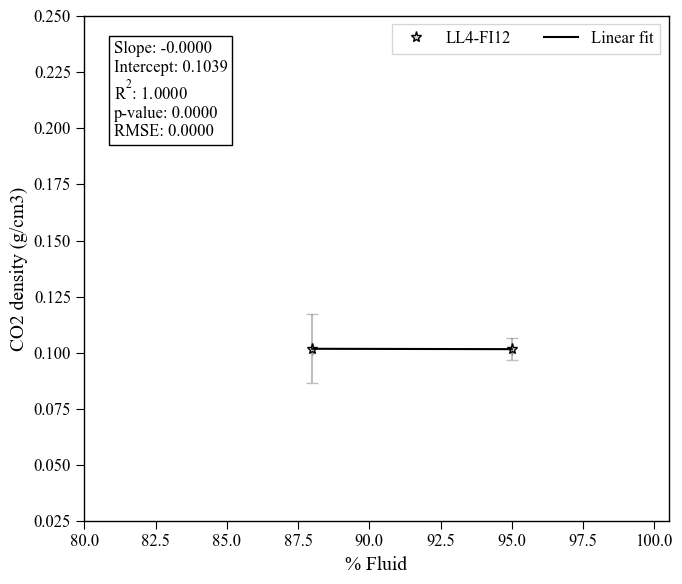

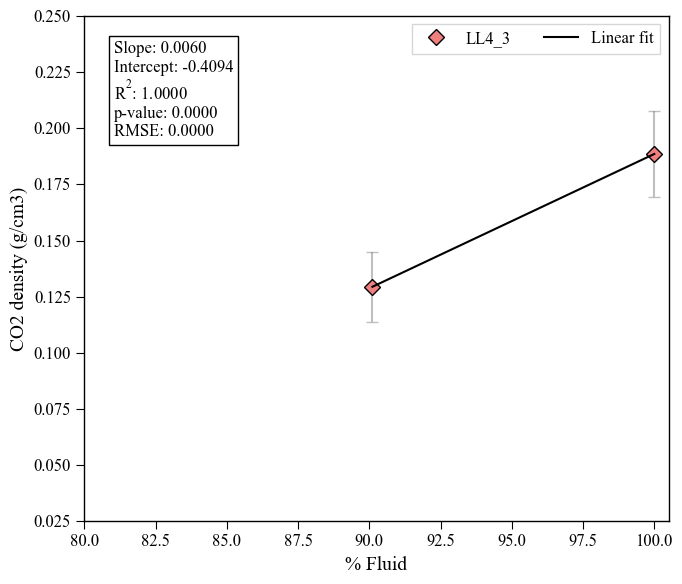

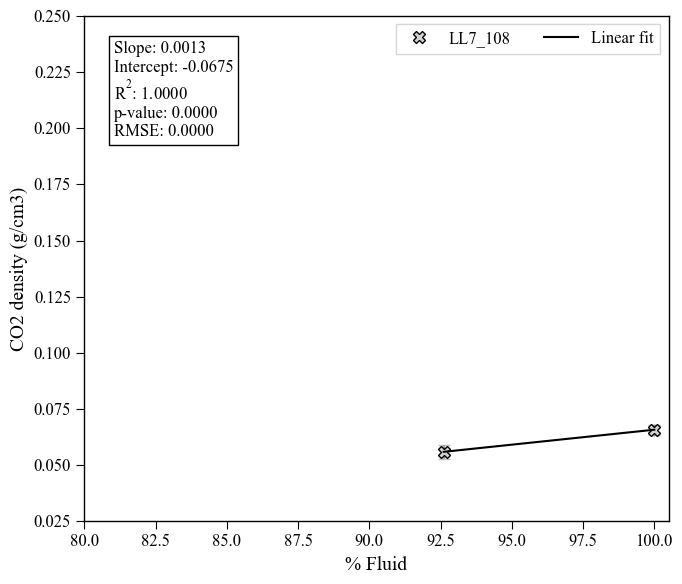

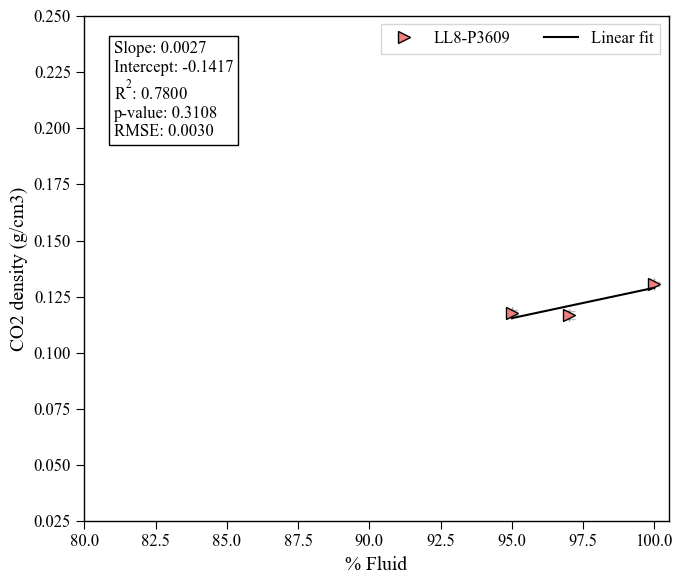

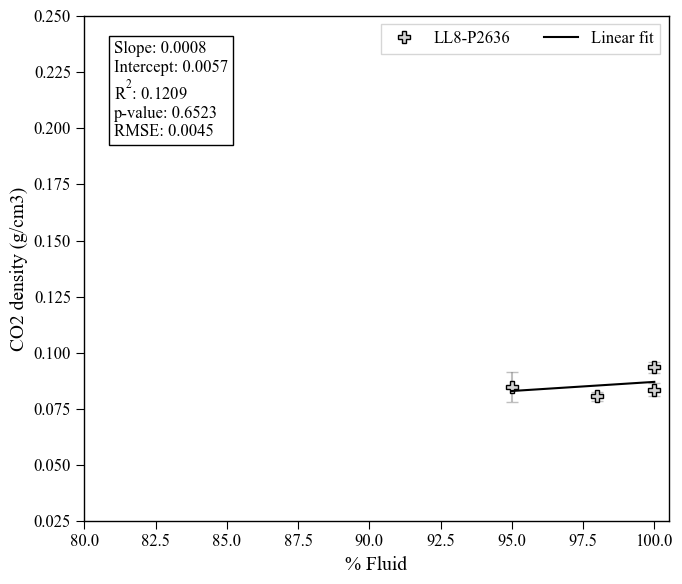

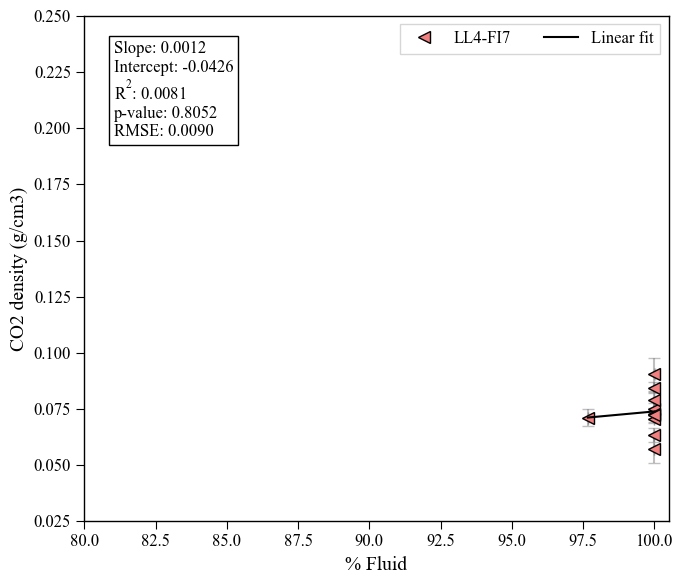

In [14]:
output_directory = figpath + '/single_xtal_FIpairs'
os.makedirs(output_directory, exist_ok=True)

xlim=[80,100.5]
ylim=[0.025,0.25]

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

## Plot 'I'


x = '% Fluid'
y = 'CO2 density (g/cm3)'

xerr = 'CO2 density 1σ (g/cm3)'  # 'CO2_err(stdev or 1sig)'
yerr = 'CO2 density 1σ (g/cm3)'  # 'CO2_err(stdev or 1sig)'
color = 'lightgrey'
colors = ['lightgrey', 'lightcoral']  # List of colors to cycle through

df_4plot=melt_nomelt_pairs.copy()
df_4plot=df_4plot.sort_values(by=x)
symbols = ['s', '^', 'o', 'd', 'v', 'p', '*', 'D', 'X', '>', 'P', '<']

# Create a list of unique values in the 'Host crystal ID' column
xtal_values = df_4plot['Host crystal ID'].unique()

# Initialize counters to keep track of the symbol and color indices
symbol_index = 0
color_index = 0


for i, xtal_value in enumerate(xtal_values):
    xtal_df = df_4plot[df_4plot['Host crystal ID'] == xtal_value]
    # Skip if there's only one value or if all 'x' values are 100
    if len(xtal_df) <= 1 or all(x == 100 for x in xtal_df[x]):
        continue
    # Create a new figure for each 'Host crystal ID' value
    fig, axes = plt.subplots(figsize=(7, 6))

    axes.errorbar(x=xtal_df[x], y=xtal_df[y], xerr=xtal_df[xerr], yerr=xtal_df[yerr],
                  marker='', linestyle="", ecolor='grey', barsabove=False, capsize=4, alpha=0.5)

    # Cycle through symbols and colors
    symbol = symbols[i % len(symbols)]
    color = colors[i % len(colors)]

    sc = axes.plot(xtal_df[x], xtal_df[y], mec='k', mfc=color, marker=symbol, markersize=8,
                   linestyle='', color=color, label=xtal_value)

    # Calculate linear regression using scipy.stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(xtal_df[x], xtal_df[y])

    # Create the regression line
    regression_line = slope * xtal_df[x] + intercept

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((regression_line - xtal_df[y]) ** 2))

    # Add a textbox with regression parameters
    textstr = (
        f'Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_value**2:.4f}\n'
        f'p-value: {p_value:.4f}\nRMSE: {rmse:.4f}'
    )
    axes.text(0.05, 0.95, textstr, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=bbox)

    # Plot the regression line
    axes.plot(xtal_df[x], regression_line, color='k', linestyle='-', label='Linear fit')

    axes.legend(ncol=3, loc='best', fontsize=12)
    axes.set_xlabel('% Fluid')
    axes.set_ylabel('CO2 density (g/cm3)')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

    # Save the individual figure
    individual_figure_name = f'FigS13_Fluid_percent_pairs_{xtal_value}.png'
    individual_figure_path = os.path.join(output_directory, individual_figure_name)
    fig.tight_layout()
    fig.savefig(individual_figure_path)


    # plt.close(fig)  # Close the figure to release resources



# FIGURE 3 - Histograms + CDF

In [15]:
## Set the dataframe to plot for the histograms

lei_fi_plotting_df=lei_df.copy() ## This one was filtered for fluid>80% and bad spec out

###

P_kbar=mis['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)']/1000

Depth_ryan_lerner=pf.convert_pressure_to_depth(P_kbar=P_kbar,
                model='ryan_lerner')

mis['Depth_RL(km)']=Depth_ryan_lerner

In [16]:
## This preps the data for the CDF plots and calculates MafiCH sat Ps for Penny's MI

import MafiCH_satPs as mch

## This sets the working folder, if you place all your files in the same folder as the script and notebook, no need to change this line.
working_folder=os.getcwd()

## This sets the path to the input file created by create_mafich_inputfile
satpressinput = working_folder+'/'+ 'MafiCH_satpress_input.csv'

## This sets the path to the output file
satpressoutput = working_folder+'/'+'MafiCH_satpress_output.csv'

## Load in your data

Sample_Data=mis.copy()

## Set your column names (RESPECT THE ORDER!!!!)
# LLs samples

sample_cols = ['Sample Name',	
                'H2O (wt%) (wt%, PEC-corr)',	
                'Total CO2 (glass + bubble, ppm)',	
                'SiO2 (wt%, PEC-corr)',	
                'TiO2 (wt%, PEC-corr)',	
                'Al2O3 (wt%, PEC-corr)',	
                'FeO (wt%, PEC-corr)',	
                'MnO (wt%, PEC-corr)',	
                'MgO (wt%, PEC-corr)',	
                'CaO (wt%, PEC-corr)',	
                'Na2O (wt%, PEC-corr)',	
                'K2O (wt%, PEC-corr)',	
                'P2O5 (wt%, PEC-corr)']


## CREATE THE INPUT FILE
mch.create_mafich_inputfile(Sample_Data,sample_cols)

SatP_MafiCH_LLs=mch.run_mafich(satpressinput,satpressoutput)
SatP_MafiCH_LLs


mis_wMafiCH=pd.merge(mis,SatP_MafiCH_LLs[['sample','Pressure (bar)',	'XfH2O']],left_on='Sample Name',right_on='sample')
mis_wMafiCH = mis_wMafiCH.rename(columns={'sample': 'sample_MafiCH', 'Pressure (bar)': 'MafiCH Saturation Pressure (Total CO2 - PEC corrected)', 'XfH2O': 'MafiCH XfH2O'})
mis_wMafiCH

mis_wMafiCH['Magmasat_err4cdf']=mis_wMafiCH['Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)']-mis_wMafiCH['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)']

,sample,dissolved H2O wt%,dissolved CO2 ppm,wt% SiO2,wt% TiO2,wt% Al2O3,wt% FeO,wt% MnO,wt% MgO,wt% CaO,wt% Na2O,wt% K2O,wt% P2O5
0,LL8_613b,0.206067,248.344846,49.770,2.394,12.900,11.336,0.142,9.328,10.702,2.469,0.349,0.229
1,LL8_615,0.182499,397.739083,49.676,1.815,10.928,11.336,0.151,13.612,9.435,2.131,0.334,0.229
2,LL8_617_a,0.181196,468.581356,49.028,2.009,11.323,11.338,0.135,13.349,9.757,2.092,0.324,0.291
3,LL8_623_b,0.170695,1001.964557,48.418,2.448,11.895,11.331,0.177,12.514,10.022,2.103,0.449,0.299
4,LL8_626,0.178975,629.467127,49.215,2.027,11.612,11.331,0.172,12.783,9.789,2.181,0.330,0.209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,LL8_400_b,0.173048,34.826259,49.508,2.100,10.774,11.335,0.187,13.183,9.887,2.080,0.337,0.258
99,LL8_155_c,0.184080,64.044277,49.468,1.999,11.505,11.338,0.168,12.453,9.948,2.286,0.266,0.207
100,LL4_39b,0.287698,260.403876,51.579,2.151,13.568,11.409,0.164,6.799,10.503,2.723,0.381,0.257
101,LL7_205b,0.179658,34.010063,50.008,2.059,11.842,11.338,0.173,11.378,9.999,2.276,0.385,0.186


In [17]:
### this is what is needed for the CDF plots

## This is to make equidistant colors from a colorblind safe palette for the CDF plots

import matplotlib.cm as cm

# Get the coolwarm colormap
coolwarm_cmap = cm.get_cmap('cividis')

# Specify the number of equidistant colors
num_colors = 5

# Generate equidistant color values from the colormap
equidistant_colors = coolwarm_cmap(np.linspace(0, 1, num_colors))
equidistant_colors=['darkorange','teal','maroon','grey','gold','midnightblue']

sorted_lei_data = {
    'MSAT_LL4': mis_wMafiCH[['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL4')].sort_values(by='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'SHISHKINA_LL4': mis_wMafiCH[['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL4')].sort_values(by='Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'IM_LL4': mis_wMafiCH[['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL4')].sort_values(by='Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'MAFICH_LL4': mis_wMafiCH[['MafiCH Saturation Pressure (Total CO2 - PEC corrected)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL4')].sort_values(by='MafiCH Saturation Pressure (Total CO2 - PEC corrected)')/ 1000,
    'VOLATILECALC_LL4': mis_wMafiCH[['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL4')].sort_values(by='VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)')/ 1000,

    'FI_LL4':lei_df[['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)','Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)']][lei_df['Fluid inclusion ID'].str.contains('LL4')].sort_values(by='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'),

    'MSAT_LL8': mis_wMafiCH[['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL8')].sort_values(by='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'SHISHKINA_LL8': mis_wMafiCH[['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL8')].sort_values(by='Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'IM_LL8': mis_wMafiCH[['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL8')].sort_values(by='Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'MAFICH_LL8': mis_wMafiCH[['MafiCH Saturation Pressure (Total CO2 - PEC corrected)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL8')].sort_values(by='MafiCH Saturation Pressure (Total CO2 - PEC corrected)')/ 1000,
    'VOLATILECALC_LL8': mis_wMafiCH[['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL8')].sort_values(by='VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)')/ 1000,

    'FI_LL8':lei_df[['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)','Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)']][lei_df['Fluid inclusion ID'].str.contains('LL8')].sort_values(by='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'),

    'MSAT_LL7': mis_wMafiCH[['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL7')].sort_values(by='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'SHISHKINA_LL7': mis_wMafiCH[['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL7')].sort_values(by='Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'IM_LL7': mis_wMafiCH[['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL7')].sort_values(by='Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)')/ 1000,
    'MAFICH_LL7': mis_wMafiCH[['MafiCH Saturation Pressure (Total CO2 - PEC corrected)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL7')].sort_values(by='MafiCH Saturation Pressure (Total CO2 - PEC corrected)')/ 1000,
    'VOLATILECALC_LL7': mis_wMafiCH[['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)','Magmasat_err4cdf']][mis_wMafiCH['Sample_ID'].str.contains('LL7')].sort_values(by='VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)')/ 1000,

    'FI_LL7':lei_df[['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)','Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)']][lei_df['Fluid inclusion ID'].str.contains('LL7')].sort_values(by='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)')
}

MI_linewidth=2
FI_linewidth=3


# The dictionary containing the data and plot properties
data_and_properties = {
        'MSAT_LL4': {
        'data': sorted_lei_data['MSAT_LL4']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': sorted_lei_data['MSAT_LL4']['Magmasat_err4cdf'],
        'properties': {'linewidth':MI_linewidth, 'label': 'MSAT', 'color': equidistant_colors[0],'linestyle':'-.'}
    },
        'SHISHKINA_LL4': {
        'data': sorted_lei_data['SHISHKINA_LL4']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'SHISHKINA', 'color': equidistant_colors[1]}
    },
        'IM_LL4': {
        'data': sorted_lei_data['IM_LL4']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'IM', 'color': equidistant_colors[2]}
    },
        'MAFICH_LL4': {
        'data': sorted_lei_data['MAFICH_LL4']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'MAFICH', 'color': equidistant_colors[3]}
    },
        'VOLATILECALC_LL4': {
        'data': sorted_lei_data['VOLATILECALC_LL4']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'VOLATILECALC', 'color': equidistant_colors[4]}
    },
        'MSAT_LL8': {
        'data': sorted_lei_data['MSAT_LL8']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': sorted_lei_data['MSAT_LL8']['Magmasat_err4cdf'],
        'properties': {'linewidth': MI_linewidth, 'label': 'MSAT', 'color':  equidistant_colors[0]}
    },
        'SHISHKINA_LL8': {
        'data': sorted_lei_data['SHISHKINA_LL8']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'SHISHKINA', 'color': equidistant_colors[1]}
    },
        'IM_LL8': {
        'data': sorted_lei_data['IM_LL8']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'IM', 'color': equidistant_colors[2]}
    },
        'MAFICH_LL8': {
        'data': sorted_lei_data['MAFICH_LL8']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'MAFICH', 'color': equidistant_colors[3]}
    },
        'VOLATILECALC_LL8': {
        'data': sorted_lei_data['VOLATILECALC_LL8']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'VOLATILECALC', 'color': equidistant_colors[4]}
    },
        'MSAT_LL7': {
        'data': sorted_lei_data['MSAT_LL7']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': sorted_lei_data['MSAT_LL7']['Magmasat_err4cdf'],
        'properties': {'linewidth': MI_linewidth, 'label': 'MSAT', 'color':  equidistant_colors[0]}
    },
        'SHISHKINA_LL7': {
        'data': sorted_lei_data['SHISHKINA_LL7']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'SHISHKINA', 'color': equidistant_colors[1]}
    },
        'IM_LL7': {
        'data': sorted_lei_data['IM_LL7']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'IM', 'color': equidistant_colors[2]}
    },
        'MAFICH_LL7': {
        'data': sorted_lei_data['MAFICH_LL7']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'MAFICH', 'color': equidistant_colors[3]}
    },
        'VOLATILECALC_LL7': {
        'data': sorted_lei_data['VOLATILECALC_LL7']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'],
        'error_data': 0,
        'properties': {'linewidth': MI_linewidth, 'label': 'VOLATILECALC', 'color': equidistant_colors[4]}
    },
        'FI_LL4': {
        'data': sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'],
        'error_data': sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'],
        'properties': {'linewidth': FI_linewidth, 'label': 'FI', 'color':  equidistant_colors[5]}  
    },
        'FI_LL8': {
        'data': sorted_lei_data['FI_LL8']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'],
        'error_data': sorted_lei_data['FI_LL8']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'],
        'properties': {'linewidth': FI_linewidth, 'label': 'FI', 'color': equidistant_colors[5]}  
    },
        'FI_LL7': {
        'data': sorted_lei_data['FI_LL7']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'],
        'error_data': sorted_lei_data['FI_LL7']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'],
        'properties': {'linewidth': FI_linewidth, 'label': 'FI', 'color': equidistant_colors[5]}  
    },
}

C:\Users\charl\AppData\Local\Temp\ipykernel_25784\4256009485.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  coolwarm_cmap = cm.get_cmap('cividis')


## Bootstrap KS function

In [18]:
from scipy import stats
def calc_critKS_D(x1,x2,calpha=1.36):
    criticalksD=calpha*np.sqrt((len(x1)+len(x2))/(len(x1)*len(x2)))
    return criticalksD

def calculate_bootstrap_ks(data1, data2, data1_err, data2_err, iterations=2000,plot=True,plot_method='plot',xlabel="Pressure (kbar)"):
    # plot_method can be 'plot' to get a simple CDF, smoothed. If anything else, it will use step function to plot.
    # if plot is true, a figure is produced, if anything else it will not plot. 

    def calculate_ks_stat(data1, data2):
        return stats.ks_2samp(data1, data2)

    bootstrap_ks_stats = []
    bootstrap_p_values = []
    resampled_distributions = []

    for _ in range(iterations):
        data1_resample = np.random.normal(data1, data1_err)
        data2_resample = np.random.normal(data2, data2_err)
        
        ks_result = calculate_ks_stat(data1_resample, data2_resample)
        bootstrap_ks_stats.append(ks_result.statistic)
        bootstrap_p_values.append(ks_result.pvalue)
        
        resampled_distributions.append({
            'data1_resample': np.sort(data1_resample),
            'data2_resample': np.sort(data2_resample),
        })

    bootstrap_ks_stats = np.array(bootstrap_ks_stats)
    bootstrap_p_values = np.array(bootstrap_p_values)

    data1_resample_sorted = np.sort(data1_resample)
    data2_resample_sorted = np.sort(data2_resample)

    original_ks_stat, original_p_value = calculate_ks_stat(data1, data2)
    critD=calc_critKS_D(data1_resample_sorted,data2_resample_sorted)

    results = {
        'original_ks_stat': original_ks_stat,
        'original_p_value': original_p_value,
        'critical D-val':critD,
        'bootstrap_ks_stats': bootstrap_ks_stats,
        'bootstrap_p_values': bootstrap_p_values,
        'bootstrap_ks_mean': np.mean(bootstrap_ks_stats),
        'bootstrap_ks_std': np.std(bootstrap_ks_stats),
        'bootstrap_p_mean': np.mean(bootstrap_p_values),
        'bootstrap_p_std': np.std(bootstrap_p_values),
        'data1_resample_sorted': data1,
        'data2_resample_sorted': data2,
        'resampled_distributions': resampled_distributions,
    }

    if plot!=False:
        fig,ax=plt.subplots(1,1, figsize=(7, 5))
        # This plots all the bootstraped CDF 
        for i, distribution in enumerate(results['resampled_distributions']):
            if plot_method!='plot':
                ax.step(np.concatenate([distribution['data1_resample'],distribution['data1_resample'][-1:]]),np.arange(distribution['data1_resample'].size + 1) / distribution['data1_resample'].size, color='royalblue',alpha=0.2)
                ax.step(np.concatenate([distribution['data2_resample'],distribution['data2_resample'][-1:]]),np.arange(distribution['data2_resample'].size + 1) / distribution['data2_resample'].size, color='wheat',alpha=0.2)
            else:
                ax.plot(np.sort(distribution['data1_resample']), np.arange(1, len(distribution['data1_resample']) + 1) / len(distribution['data1_resample']), color='royalblue', alpha=0.2)
                ax.plot(np.sort(distribution['data2_resample']), np.arange(1, len(distribution['data2_resample']) + 1) / len(distribution['data2_resample']), color='wheat', alpha=0.2)
        

        # This plots the original data CDF
        if plot_method!='plot':
            ax.step(np.concatenate([results['data1_resample_sorted'],results['data1_resample_sorted'][-1:]]),np.arange(results['data1_resample_sorted'].size + 1) / results['data1_resample_sorted'].size, color='midnightblue', linewidth=2,label='Data1')
            ax.step(np.concatenate([results['data2_resample_sorted'],results['data2_resample_sorted'][-1:]]),np.arange(results['data2_resample_sorted'].size + 1) / results['data2_resample_sorted'].size, color='darkorange', linewidth=2,label='Data2')
        else:
            ax.plot(results['data1_resample_sorted'], np.arange(1, len(results['data1_resample_sorted']) + 1) / len(results['data1_resample_sorted']), color='midnightblue',linewidth=2, label='Data1')
            ax.plot(results['data2_resample_sorted'], np.arange(1, len(results['data2_resample_sorted']) + 1) / len(results['data2_resample_sorted']), color='darkorange',linewidth=2, label='Data2')

        # This creates a text box with all the statistics
        mean_ks_text = f"MC KS Mean: {results['bootstrap_ks_mean']:.3f} ± {results['bootstrap_ks_std']:.3f}"
        mean_p_text = f"MC P-val Mean: {results['bootstrap_p_mean']:.3f} ± {results['bootstrap_p_std']:.3f}"
        text_box = f"Sample KS Statistic: {results['original_ks_stat']:.3f}\nSample P-val: {results['original_p_value']:.3f}\nCritical KS D: {critD:.3f}\n{mean_ks_text}\n{mean_p_text}"

        ax.text(0.55, 0.5, text_box, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        ax.set_xlim([0,max(data1.max(), data2.max())])
        ax.legend()
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Cumulative probability")
    
    if 'fig' in locals():
        final_result=fig,results
    else:
        final_result=results
    
    return final_result



# ###### SET YOUR DATA ENTRIES AND ITERATIONS##### Example here
# fill4_data = sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'] #data 1 -pd.Series, sorted
# fill4_errors = sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'] #data 1 error

# msatll4_data = sorted_lei_data['MSAT_LL4']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)']#data 2
# msatll4_errors = sorted_lei_data['MSAT_LL4']['Magmasat_err4cdf'] #data 2 error

# iterations=1000

# # Calculate the results don't call fig if you didn't say plot=True
# final_result= calculate_bootstrap_ks(fill4_data, msatll4_data, fill4_errors, msatll4_errors, iterations=iterations,plot=True,plot_method='step',xlabel="Pressure (kbar)")


In [19]:
## LL4 ##
MIcombo_df4 = pd.concat([sorted_lei_data['MSAT_LL4']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'].rename('MSAT(kbar)').sort_index(), 
                        sorted_lei_data['SHISHKINA_LL4']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('SHISHKINA(kbar)').sort_index(), 
                        sorted_lei_data['IM_LL4']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('IM(kbar)').sort_index(), 
                        sorted_lei_data['MAFICH_LL4']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'].rename('MAFICH(kbar)').sort_index(), 
                        sorted_lei_data['VOLATILECALC_LL4']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'].rename('VOLATILECALC(kbar)').sort_index()], 
                        axis=1)

average_sol_model4=pd.DataFrame({})
average_sol_model4['mean'] = MIcombo_df4.mean(axis=1)
average_sol_model4['std'] = MIcombo_df4.std(axis=1)


In [20]:
## LL4 ##
MIcombo_df4 = pd.concat([sorted_lei_data['MSAT_LL4']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'].rename('MSAT(kbar)').sort_index(), 
                        sorted_lei_data['SHISHKINA_LL4']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('SHISHKINA(kbar)').sort_index(), 
                        sorted_lei_data['IM_LL4']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('IM(kbar)').sort_index(), 
                        sorted_lei_data['MAFICH_LL4']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'].rename('MAFICH(kbar)').sort_index(), 
                        sorted_lei_data['VOLATILECALC_LL4']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'].rename('VOLATILECALC(kbar)').sort_index()], 
                        axis=1)

average_sol_model4=pd.DataFrame({})
average_sol_model4['mean'] = MIcombo_df4.mean(axis=1)
average_sol_model4['std'] = MIcombo_df4.std(axis=1)
sol_model_l4_error_index_sorted=sorted_lei_data['MSAT_LL4']['Magmasat_err4cdf'].sort_index()
average_sol_model4['quadrature_err']=np.sqrt((sol_model_l4_error_index_sorted**2)*5)

MIcombo_df4['AVG_SOLMODEL(kbar)']=average_sol_model4['mean'].copy()
MIcombo_df4['AVG_SOLMODEL_STD(kbar)']=average_sol_model4['quadrature_err'].copy()
MIcombo_df4['SOLMODEL_ERRORS(kbar)']=sorted_lei_data['MSAT_LL4']['Magmasat_err4cdf'].rename('MI_error(kbar)').sort_index() 


FIcombo_df4=pd.DataFrame({})
FIcombo_df4['FI(kbar)']=sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'].rename('FI(kbar)').sort_index()
FIcombo_df4['FI_error(kbar)']=sorted_lei_data['FI_LL4']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'].rename('FI_error(kbar)').sort_index() #data 1 error

## LL7 ##
MIcombo_df7 = pd.concat([sorted_lei_data['MSAT_LL7']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'].rename('MSAT(kbar)').sort_index(), 
                        sorted_lei_data['SHISHKINA_LL7']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('SHISHKINA(kbar)').sort_index(), 
                        sorted_lei_data['IM_LL7']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('IM(kbar)').sort_index(), 
                        sorted_lei_data['MAFICH_LL7']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'].rename('MAFICH(kbar)').sort_index(), 
                        sorted_lei_data['VOLATILECALC_LL7']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'].rename('VOLATILECALC(kbar)').sort_index()], 
                        axis=1)

average_sol_model7=pd.DataFrame({})
average_sol_model7['mean'] = MIcombo_df7.mean(axis=1)
average_sol_model7['std'] = MIcombo_df7.std(axis=1)

MIcombo_df7['AVG_SOLMODEL(kbar)']=average_sol_model7['mean'].copy()
MIcombo_df7['AVG_SOLMODEL_STD(kbar)']=average_sol_model7['std'].copy()
MIcombo_df7['SOLMODEL_ERRORS(kbar)']=sorted_lei_data['MSAT_LL7']['Magmasat_err4cdf'].rename('MI_error(kbar)').sort_index() 


FIcombo_df7=pd.DataFrame({})
FIcombo_df7['FI(kbar)']=sorted_lei_data['FI_LL7']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'].rename('FI(kbar)').sort_index()
FIcombo_df7['FI_error(kbar)']=sorted_lei_data['FI_LL7']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'].rename('FI_error(kbar)').sort_index() #data 1 error

## LL8 ##
MIcombo_df8 = pd.concat([sorted_lei_data['MSAT_LL8']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'].rename('MSAT(kbar)').sort_index(), 
                        sorted_lei_data['SHISHKINA_LL8']['Shishkina  Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('SHISHKINA(kbar)').sort_index(), 
                        sorted_lei_data['IM_LL8']['Iacono-Marziano Saturation Pressure (bar)  (Total, PEC-corr CO2, Measured H2O)'].rename('IM(kbar)').sort_index(), 
                        sorted_lei_data['MAFICH_LL8']['MafiCH Saturation Pressure (Total CO2 - PEC corrected)'].rename('MAFICH(kbar)').sort_index(), 
                        sorted_lei_data['VOLATILECALC_LL8']['VolatileCalc Saturation pressure macro (bar)  (Total, PEC-corr CO2,  Measured H2O)'].rename('VOLATILECALC(kbar)').sort_index()], 
                        axis=1)

average_sol_model8=pd.DataFrame({})
average_sol_model8['mean'] = MIcombo_df8.mean(axis=1)
average_sol_model8['std'] = MIcombo_df8.std(axis=1)

MIcombo_df8['AVG_SOLMODEL(kbar)']=average_sol_model8['mean'].copy()
MIcombo_df8['AVG_SOLMODEL_STD(kbar)']=average_sol_model8['std'].copy()
MIcombo_df8['SOLMODEL_ERRORS(kbar)']=sorted_lei_data['MSAT_LL8']['Magmasat_err4cdf'].rename('MI_error(kbar)').sort_index() 


FIcombo_df8=pd.DataFrame({})
FIcombo_df8['FI(kbar)']=sorted_lei_data['FI_LL8']['Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'].rename('FI(kbar)').sort_index()
FIcombo_df8['FI_error(kbar)']=sorted_lei_data['FI_LL8']['Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'].rename('FI_error(kbar)').sort_index() #data 1 error

#### DISPLAY DATA #########
display(MIcombo_df4.head(2))
display(FIcombo_df4.head(2))
display(MIcombo_df7.head(2))
display(FIcombo_df7.head(2))
display(MIcombo_df8.head(2))
display(FIcombo_df8.head(2))

,MSAT(kbar),SHISHKINA(kbar),IM(kbar),MAFICH(kbar),VOLATILECALC(kbar),AVG_SOLMODEL(kbar),AVG_SOLMODEL_STD(kbar),SOLMODEL_ERRORS(kbar)
28,0.56,0.701795,0.828804,0.336,0.819,0.649120,0.402492,0.18
29,0.83,0.975601,1.275725,0.559,1.323,0.992665,1.118034,0.50


,FI(kbar),FI_error(kbar)
0,0.615353,0.079877
1,0.630036,0.080094


,MSAT(kbar),SHISHKINA(kbar),IM(kbar),MAFICH(kbar),VOLATILECALC(kbar),AVG_SOLMODEL(kbar),AVG_SOLMODEL_STD(kbar),SOLMODEL_ERRORS(kbar)
40,0.33,0.423004,0.540101,0.208,0.572,0.414621,0.150363,0.22
41,0.47,0.592691,0.760420,0.308,0.799,0.586022,0.204069,0.45


,FI(kbar),FI_error(kbar)
51,1.018178,0.099889
52,0.748562,0.084770


,MSAT(kbar),SHISHKINA(kbar),IM(kbar),MAFICH(kbar),VOLATILECALC(kbar),AVG_SOLMODEL(kbar),AVG_SOLMODEL_STD(kbar),SOLMODEL_ERRORS(kbar)
0,0.36,0.465390,0.602794,0.247,0.6530,0.465637,0.167987,0.25
1,0.43,0.528862,0.695036,0.276,0.7695,0.539879,0.199140,0.17


,FI(kbar),FI_error(kbar)
73,0.296119,0.066362
74,0.435983,0.075542


In [21]:
## this function to help plot the MC results on the big fig

def plot_distribution(ax, KS_MC_results, legend_title='title', data1label='data1',data2label='data2', xlabel='value',xlim=[0, 4],ylim=[0, 1]):

    for i, distribution in enumerate(KS_MC_results['resampled_distributions']):
        ax.step(
            np.concatenate([distribution['data2_resample'], distribution['data2_resample'][-1:]]),
            np.arange(distribution['data2_resample'].size + 1) / distribution['data2_resample'].size,
            color='wheat', alpha=0.2
        )
        ax.step(
            np.concatenate([distribution['data1_resample'], distribution['data1_resample'][-1:]]),
            np.arange(distribution['data1_resample'].size + 1) / distribution['data1_resample'].size,
            color='royalblue', alpha=0.2
        )

    ax.step(
        np.concatenate([KS_MC_results['data2_resample_sorted'], KS_MC_results['data2_resample_sorted'][-1:]]),
        np.arange(KS_MC_results['data2_resample_sorted'].size + 1) / KS_MC_results['data2_resample_sorted'].size,
        color='darkorange', linewidth=2, label=data2label
    )
    ax.step(
        np.concatenate([KS_MC_results['data1_resample_sorted'], KS_MC_results['data1_resample_sorted'][-1:]]),
        np.arange(KS_MC_results['data1_resample_sorted'].size + 1) / KS_MC_results['data1_resample_sorted'].size,
        color='midnightblue', linewidth=2, label=data1label
    )

    mean_ks_text = f"MC KS Mean: {KS_MC_results['bootstrap_ks_mean']:.3f} ± {KS_MC_results['bootstrap_ks_std']:.3f}"
    mean_p_text = f"MC P-val Mean: {KS_MC_results['bootstrap_p_mean']:.3f} ± {KS_MC_results['bootstrap_p_std']:.3f}"
    text_box = f"Sample KS Statistic: {KS_MC_results['original_ks_stat']:.3f}\nSample P-val: {KS_MC_results['original_p_value']:.3f}\nCritical KS D: {KS_MC_results['critical D-val']:.3f}\n{mean_ks_text}\n{mean_p_text}"
    
    ax.text(0.4, 0.4, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=legend_title, loc="lower right")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Cumulative probability")


In [22]:
def plot_distribution(ax, KS_MC_results, legend_title='title', fontsize=10,data1label='data1', data2label='data2', xlabel='value', xlim=[0, 4], ylim=[0, 1], flip_axes=False,stats_box_pos=(0.4,0.4)):
    if flip_axes:
        x_label = "Cumulative probability"
        y_label = xlabel
    else:
        x_label = xlabel
        y_label = "Cumulative probability"
        
    for i, distribution in enumerate(KS_MC_results['resampled_distributions']):
        if flip_axes:
            ax.step(
                np.arange(distribution['data2_resample'].size + 1) / distribution['data2_resample'].size,
                np.concatenate([distribution['data2_resample'], distribution['data2_resample'][-1:]]),
                color='wheat', alpha=0.2
            )
            ax.step(
                np.arange(distribution['data1_resample'].size + 1) / distribution['data1_resample'].size,
                np.concatenate([distribution['data1_resample'], distribution['data1_resample'][-1:]]),
                color='royalblue', alpha=0.2
            )
        else:
            ax.step(
                np.concatenate([distribution['data2_resample'], distribution['data2_resample'][-1:]]),
                np.arange(distribution['data2_resample'].size + 1) / distribution['data2_resample'].size,
                color='wheat', alpha=0.2
            )
            ax.step(
                np.concatenate([distribution['data1_resample'], distribution['data1_resample'][-1:]]),
                np.arange(distribution['data1_resample'].size + 1) / distribution['data1_resample'].size,
                color='royalblue', alpha=0.2
            )

    if flip_axes:
        ax.step(
            np.arange(KS_MC_results['data2_resample_sorted'].size + 1) / KS_MC_results['data2_resample_sorted'].size,
            np.concatenate([KS_MC_results['data2_resample_sorted'], KS_MC_results['data2_resample_sorted'][-1:]]),
            color='darkorange', linewidth=2, label=data2label
        )
        ax.step(
            np.arange(KS_MC_results['data1_resample_sorted'].size + 1) / KS_MC_results['data1_resample_sorted'].size,
            np.concatenate([KS_MC_results['data1_resample_sorted'], KS_MC_results['data1_resample_sorted'][-1:]]),
            color='midnightblue', linewidth=2, label=data1label
        )
    else:
        ax.step(
            np.concatenate([KS_MC_results['data2_resample_sorted'], KS_MC_results['data2_resample_sorted'][-1:]]),
            np.arange(KS_MC_results['data2_resample_sorted'].size + 1) / KS_MC_results['data2_resample_sorted'].size,
            color='darkorange', linewidth=2, label=data2label
        )
        ax.step(
            np.concatenate([KS_MC_results['data1_resample_sorted'], KS_MC_results['data1_resample_sorted'][-1:]]),
            np.arange(KS_MC_results['data1_resample_sorted'].size + 1) / KS_MC_results['data1_resample_sorted'].size,
            color='midnightblue', linewidth=2, label=data1label
        )

    mean_ks_text = f"MC KS Mean: {KS_MC_results['bootstrap_ks_mean']:.3f} ± {KS_MC_results['bootstrap_ks_std']:.3f}"
    mean_p_text = f"MC P-val Mean: {KS_MC_results['bootstrap_p_mean']:.3f} ± {KS_MC_results['bootstrap_p_std']:.3f}"
    text_box = f"Sample KS Statistic: {KS_MC_results['original_ks_stat']:.3f}\nSample P-val: {KS_MC_results['original_p_value']:.3f}\nCritical KS D: {KS_MC_results['critical D-val']:.3f}\n{mean_ks_text}\n{mean_p_text}"
    
    ax.text(stats_box_pos[0],stats_box_pos[1], text_box, fontsize=fontsize, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=legend_title, loc="best",fontsize=fontsize)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


In [23]:
# Prep the data #
data_dict = {
    'LL4': {},
    'LL7': {},
    'LL8': {}
}

# For LL4
fi_data4_sorted = FIcombo_df4.sort_values(by='FI(kbar)')
mi_data4msat_sorted=MIcombo_df4[['MSAT(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MSAT(kbar)')
mi_data4sh_sorted=MIcombo_df4[['SHISHKINA(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='SHISHKINA(kbar)')
mi_data4im_sorted=MIcombo_df4[['IM(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='IM(kbar)')
mi_data4mch_sorted=MIcombo_df4[['MAFICH(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MAFICH(kbar)')
mi_data4vc_sorted=MIcombo_df4[['VOLATILECALC(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='VOLATILECALC(kbar)')
mi_data4avg_sorted=MIcombo_df4[['AVG_SOLMODEL(kbar)','AVG_SOLMODEL_STD(kbar)']].sort_values(by='AVG_SOLMODEL(kbar)')

data_dict['LL4']['fi_data'] = fi_data4_sorted['FI(kbar)']
data_dict['LL4']['fi_data_err'] = fi_data4_sorted['FI_error(kbar)']
data_dict['LL4']['mi_data_msat'] = mi_data4msat_sorted['MSAT(kbar)']
data_dict['LL4']['mi_data_msat_errors'] = mi_data4msat_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL4']['mi_data_sh'] = mi_data4sh_sorted['SHISHKINA(kbar)']
data_dict['LL4']['mi_data_sh_errors'] = mi_data4sh_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL4']['mi_data_im'] = mi_data4im_sorted['IM(kbar)']
data_dict['LL4']['mi_data_im_errors'] = mi_data4im_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL4']['mi_data_mch'] = mi_data4mch_sorted['MAFICH(kbar)']
data_dict['LL4']['mi_data_mch_errors'] = mi_data4mch_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL4']['mi_data_vc'] = mi_data4vc_sorted['VOLATILECALC(kbar)']
data_dict['LL4']['mi_data_vc_errors'] = mi_data4vc_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL4']['mi_data_avg'] = mi_data4avg_sorted['AVG_SOLMODEL(kbar)']
data_dict['LL4']['mi_data_avg_errors'] = mi_data4avg_sorted['AVG_SOLMODEL_STD(kbar)']

# For LL7
fi_data7_sorted = FIcombo_df7.sort_values(by='FI(kbar)')
mi_data7msat_sorted=MIcombo_df7[['MSAT(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MSAT(kbar)')
mi_data7sh_sorted=MIcombo_df7[['SHISHKINA(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='SHISHKINA(kbar)')
mi_data7im_sorted=MIcombo_df7[['IM(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='IM(kbar)')
mi_data7mch_sorted=MIcombo_df7[['MAFICH(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MAFICH(kbar)')
mi_data7vc_sorted=MIcombo_df7[['VOLATILECALC(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='VOLATILECALC(kbar)')
mi_data7avg_sorted=MIcombo_df7[['AVG_SOLMODEL(kbar)','AVG_SOLMODEL_STD(kbar)']].sort_values(by='AVG_SOLMODEL(kbar)')

data_dict['LL7']['fi_data'] = fi_data7_sorted['FI(kbar)']
data_dict['LL7']['fi_data_err'] = fi_data7_sorted['FI_error(kbar)']
data_dict['LL7']['mi_data_msat'] = mi_data7msat_sorted['MSAT(kbar)']
data_dict['LL7']['mi_data_msat_errors'] = mi_data7msat_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL7']['mi_data_sh'] = mi_data7sh_sorted['SHISHKINA(kbar)']
data_dict['LL7']['mi_data_sh_errors'] = mi_data7sh_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL7']['mi_data_im'] = mi_data7im_sorted['IM(kbar)']
data_dict['LL7']['mi_data_im_errors'] = mi_data7im_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL7']['mi_data_mch'] = mi_data7mch_sorted['MAFICH(kbar)']
data_dict['LL7']['mi_data_mch_errors'] = mi_data7mch_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL7']['mi_data_vc'] = mi_data7vc_sorted['VOLATILECALC(kbar)']
data_dict['LL7']['mi_data_vc_errors'] = mi_data7vc_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL7']['mi_data_avg'] = mi_data7avg_sorted['AVG_SOLMODEL(kbar)']
data_dict['LL7']['mi_data_avg_errors'] = mi_data7avg_sorted['AVG_SOLMODEL_STD(kbar)']
# For LL8
fi_data8_sorted = FIcombo_df8.sort_values(by='FI(kbar)')
mi_data8msat_sorted=MIcombo_df8[['MSAT(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MSAT(kbar)')
mi_data8sh_sorted=MIcombo_df8[['SHISHKINA(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='SHISHKINA(kbar)')
mi_data8im_sorted=MIcombo_df8[['IM(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='IM(kbar)')
mi_data8mch_sorted=MIcombo_df8[['MAFICH(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='MAFICH(kbar)')
mi_data8vc_sorted=MIcombo_df8[['VOLATILECALC(kbar)','SOLMODEL_ERRORS(kbar)']].sort_values(by='VOLATILECALC(kbar)')
mi_data8avg_sorted=MIcombo_df8[['AVG_SOLMODEL(kbar)','AVG_SOLMODEL_STD(kbar)']].sort_values(by='AVG_SOLMODEL(kbar)')

data_dict['LL8']['fi_data'] = fi_data8_sorted['FI(kbar)']
data_dict['LL8']['fi_data_err'] = fi_data8_sorted['FI_error(kbar)']
data_dict['LL8']['mi_data_msat'] = mi_data8msat_sorted['MSAT(kbar)']
data_dict['LL8']['mi_data_msat_errors'] = mi_data8msat_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL8']['mi_data_sh'] = mi_data8sh_sorted['SHISHKINA(kbar)']
data_dict['LL8']['mi_data_sh_errors'] = mi_data8sh_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL8']['mi_data_im'] = mi_data8im_sorted['IM(kbar)']
data_dict['LL8']['mi_data_im_errors'] = mi_data8im_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL8']['mi_data_mch'] = mi_data8mch_sorted['MAFICH(kbar)']
data_dict['LL8']['mi_data_mch_errors'] = mi_data8mch_sorted['SOLMODEL_ERRORS(kbar)']
data_dict['LL8']['mi_data_vc'] = mi_data8vc_sorted['VOLATILECALC(kbar)']
data_dict['LL8']['mi_data_vc_errors'] = mi_data8vc_sorted['SOLMODEL_ERRORS(kbar)']

data_dict['LL8']['mi_data_avg'] = mi_data8avg_sorted['AVG_SOLMODEL(kbar)']
data_dict['LL8']['mi_data_avg_errors'] = mi_data8avg_sorted['AVG_SOLMODEL_STD(kbar)']


## This calculates the MC for the KS stat for the whole dictionary

In [24]:
# Define the number of iterations
iterations = 1000

# Create a dictionary to store the results
results_dict = {
    'LL4': {},
    'LL7': {},
    'LL8': {}
}

# Iterate through the cases (LL4, LL7, LL8)
for case in data_dict.keys():
    fi_data = data_dict[case]['fi_data']
    fi_data_err = data_dict[case]['fi_data_err']
    
    # Iterate through the calculations (msat, sh, im, mch, vc)
    for calculation in ['msat', 'sh', 'im', 'mch', 'vc','avg']:
        mi_data = data_dict[case]['mi_data_' + calculation]
        mi_data_err = data_dict[case]['mi_data_' + calculation + '_errors']
        
        # Calculate the results using the calculate_bootstrap_ks function
        results = calculate_bootstrap_ks(fi_data, mi_data, fi_data_err, mi_data_err,
                                          iterations=iterations, plot=False, plot_method='step',
                                          xlabel="Pressure (kbar)")
        
        # Store the results in the results_dict
        results_dict[case][calculation] = results


In [25]:
# Define the number of iterations
iterations = 1000

# Create a dictionary to store the results
results_dict_mpa = {
    'LL4': {},
    'LL7': {},
    'LL8': {}
}

# Iterate through the cases (LL4, LL7, LL8)
for case in data_dict.keys():
    fi_data = data_dict[case]['fi_data']
    fi_data_err = data_dict[case]['fi_data_err']
    
    # Iterate through the calculations (msat, sh, im, mch, vc)
    for calculation in ['msat', 'sh', 'im', 'mch', 'vc','avg']:
        mi_data = data_dict[case]['mi_data_' + calculation]
        mi_data_err = data_dict[case]['mi_data_' + calculation + '_errors']
        
        # Calculate the results using the calculate_bootstrap_ks function
        results = calculate_bootstrap_ks(fi_data*100, mi_data*100, fi_data_err*100, mi_data_err*100,
                                          iterations=iterations, plot=False, plot_method='step',
                                          xlabel="Pressure (MPa)")
        
        # Store the results in the results_dict
        results_dict_mpa[case][calculation] = results

## Let's calculate the stretching models

In [26]:
###### Let's model an FI (5 um) coming from South Caldera reservoir(4km @ 1300 C) and stalling at Halemaumau reservoir (1km @ 1150 C) ##############

####### Establish reservoir PTX conditions

## SC reservoir conditions
SC_depth = 4 # depth in km
melt_MgO=13 #melt MgO in wt%
SC_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ SC
model = 'ryan_lerner'
tolerance = 0.001
SC_pressure = find_P_for_kmdepth(SC_depth, model, tolerance)

## HM reservoir conditions
HM_depth = 1 # depth in km
melt_MgO=6.5 #melt MgO in wt%
HM_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ HM
model = 'ryan_lerner'
tolerance = 0.001
HM_pressure = find_P_for_kmdepth(HM_depth, model, tolerance)


####### Let's start our model

### First let's calculate the CO2 density of our 5um FI trapped at SC
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=SC_pressure,T_K=SC_temp+273.15)[0]

## Now we move the FI to HM reservoir (1km), Pinternal will change bc T=1150, we calculate Pinternal
fi_Pi_HM_initial_MPa=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=HM_temp+273.15)['P_MPa'][0]

## Now let's leave it at HM for 2 years.
# set initial parameters 
years=2
days=years * 365.25

T = HM_temp + 273.15
R0 = 1 * 10 ** -6 # FI radius in m
R0_2=20 * 10 ** -6


def calc_multiplier(R0, dist2defect_um):
    multiplier = (dist2defect_um) / (R0 * 10**6)
    return multiplier

dist2defect_list=[50,100,250,500]

b_list_R0=[calc_multiplier(R0, dist)*R0 for dist in dist2defect_list]
b_list_R0_2=[calc_multiplier(R0_2, dist)*R0_2 for dist in dist2defect_list]

b0=b_list_R0[0]
b1 = b_list_R0[1]
b2=b_list_R0[2]
b3=b_list_R0[3]

b4=b_list_R0[0]
b5 = b_list_R0[1]
b6=b_list_R0[2]
b7=b_list_R0[3]

Pinternal=fi_Pi_HM_initial_MPa
Pexternal=HM_pressure*100 ##Pressure in MPa for this model

steps=1000 #number of steps

EOS='SW96'
day_in_sec=(24*60*60)
totaltime_in_s=days*day_in_sec


def calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, T4endcalc_PD):
    results_dict = {}

    for R in R_values:
        R_name = [name for name, value in globals().items() if value is R][0]
        R_key = f'{R_name}'
        results_dict[R_key] = {}

        for idx_b, b in enumerate(b_values):
            b_key = f'b{idx_b}'
            results = findR_Pi_rho_fixedPe_euler(R=R, b=b, T=T, EOS=EOS, Pinternal=Pinternal, Pexternal=Pexternal, totaltime=totaltime_in_s, steps=steps)
            
            results['Calculated depths (km)_HMT'] = pf.convert_pressure_to_depth(P_kbar=results['Pinternal(MPa)'] / 100, model='ryan_lerner')
            results['Calculated P from rho_SCTemp (MPa)'] = pf.calculate_P_for_rho_T(EOS='SW96', CO2_dens_gcm3=results['CO2 density (g/cm3)'], T_K=T4endcalc_PD + 273.15)['P_MPa']
            results['Calculated depths (km)'] = pf.convert_pressure_to_depth(P_kbar=results['Calculated P from rho_SCTemp (MPa)'] / 100, model='ryan_lerner')
            
            results_dict[R_key][b_key] = results

    return results_dict


# Call the function with appropriate arguments
R_values = [R0, R0_2]  # Define R values
b_values = [b0, b1, b2, b3, b4, b5, b6, b7]

b_list= [b0, b1, b2, b3, b4, b5, b6, b7]

results_dict_stall = calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, SC_temp)


In [27]:
results_dict_stall['R0']['b0'].head()

,Time(s),Step,dt(s),Pexternal(MPa),Pinternal(MPa),dR/dt(m/s),Fi_radius(μm),b (distance to xtal rim -μm),ΔR/R0 (fractional change in radius),CO2 density (g/cm3),Calculated depths (km)_HMT,Calculated P from rho_SCTemp (MPa),Calculated depths (km)
0,0.0,0,0.0,21.914288,83.801243,6.880931e-17,1.000000,50.0,0.000000,0.257382,3.633866,92.895886,4.000000
1,63115.2,1,63115.2,21.914288,83.799901,6.880931e-17,1.000004,50.0,0.000004,0.257379,3.633811,92.894391,3.999940
2,126230.4,2,63115.2,21.914288,83.798559,6.880427e-17,1.000009,50.0,0.000009,0.257375,3.633757,92.892896,3.999880
3,189345.6,3,63115.2,21.914288,83.797217,6.879924e-17,1.000013,50.0,0.000013,0.257372,3.633702,92.891401,3.999821
4,252460.8,4,63115.2,21.914288,83.795875,6.879420e-17,1.000017,50.0,0.000017,0.257369,3.633648,92.889906,3.999761


In [28]:
###### Let's model an FI (5 um) coming from South Caldera reservoir(4km @ 1300 C) and erupting to surface (0km @ 1150 C) ##############

####### Establish reservoir PTX conditions

## SC reservoir conditions
SC_depth = 4 # depth in km
melt_MgO=13 #melt MgO in wt%
SC_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ SC
model = 'ryan_lerner'
tolerance = 0.001
SC_pressure = find_P_for_kmdepth(SC_depth, model, tolerance)

## surface conditions
HM_depth = 0 # depth in km
melt_MgO=6.5 #melt MgO in wt%
HM_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ HM
model = 'ryan_lerner'
tolerance = 0.001
HM_pressure = find_P_for_kmdepth(HM_depth, model, tolerance)


####### Let's start our model

### First let's calculate the CO2 density of our 5um FI trapped at SC
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=SC_pressure,T_K=SC_temp+273.15)[0]

## Now we move the FI to HM reservoir (1km), Pinternal will change bc T=1150, we calculate Pinternal
fi_Pi_HM_initial_MPa=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=HM_temp+273.15)['P_MPa'][0]

## Now let's leave it on the surface for 7 days
# set initial parameters 

days=7

T = HM_temp + 273.15
R0 = 1 * 10 ** -6 # FI radius in m
R0_2=20 * 10 ** -6


def calc_multiplier(R0, dist2defect_um):
    multiplier = (dist2defect_um) / (R0 * 10**6)
    return multiplier

dist2defect_list=[50,100,250,500]

b_list_R0=[calc_multiplier(R0, dist)*R0 for dist in dist2defect_list]
b_list_R0_2=[calc_multiplier(R0_2, dist)*R0_2 for dist in dist2defect_list]

b0=b_list_R0[0]
b1 = b_list_R0[1]
b2=b_list_R0[2]
b3=b_list_R0[3]

b4=b_list_R0[0]
b5 = b_list_R0[1]
b6=b_list_R0[2]
b7=b_list_R0[3]

Pinternal=fi_Pi_HM_initial_MPa
Pexternal=HM_pressure*100 ##Pressure in MPa for this model

steps=1000 #number of steps

EOS='SW96'
day_in_sec=(24*60*60)
totaltime_in_s=days*day_in_sec

# Call the function with appropriate arguments
R_values = [R0, R0_2]  # Define R values
b_values = [b0, b1, b2, b3, b4, b5, b6, b7]

b_list= [b0, b1, b2, b3, b4, b5, b6, b7]

results_dict_surface = calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, SC_temp)

In [29]:
results_dict_surface['R0']['b0'].head()

,Time(s),Step,dt(s),Pexternal(MPa),Pinternal(MPa),dR/dt(m/s),Fi_radius(μm),b (distance to xtal rim -μm),ΔR/R0 (fractional change in radius),CO2 density (g/cm3),Calculated depths (km)_HMT,Calculated P from rho_SCTemp (MPa),Calculated depths (km)
0,0.0,0,0.0,0.0,83.801243,2.049236e-16,1.0,50.0,0.000000e+00,0.257382,3.633866,92.895886,4.000000
1,604.8,1,604.8,0.0,83.801205,2.049236e-16,1.0,50.0,1.239378e-07,0.257382,3.633864,92.895844,3.999998
2,1209.6,2,604.8,0.0,83.801166,2.049233e-16,1.0,50.0,2.478754e-07,0.257382,3.633862,92.895801,3.999997
3,1814.4,3,604.8,0.0,83.801128,2.049230e-16,1.0,50.0,3.718129e-07,0.257382,3.633861,92.895758,3.999995
4,2419.2,4,604.8,0.0,83.801090,2.049227e-16,1.0,50.0,4.957501e-07,0.257382,3.633859,92.895716,3.999993


## FIGURE 3 revised version

In [31]:
# mis.to_excel(r"C:\Users\charl\Desktop\RapidResponse\helperfiles\MI_kil18.xlsx")
# lei_fi_plotting_df.to_excel(r"C:\Users\charl\Desktop\RapidResponse\helperfiles\FI_kil18.xlsx")

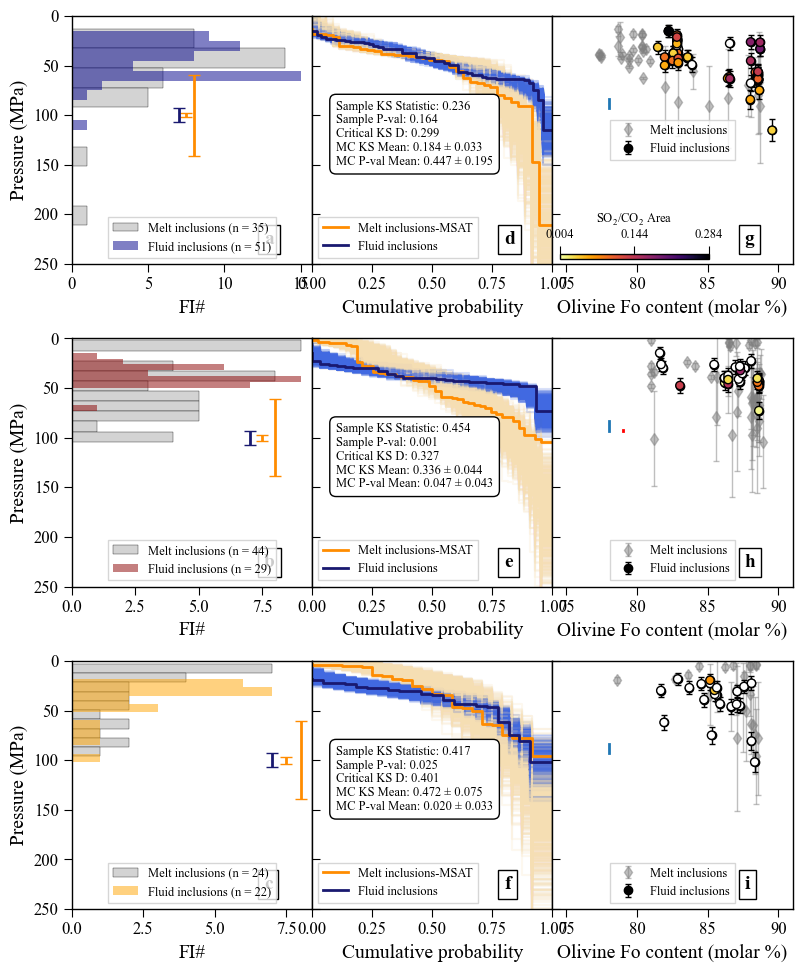

In [32]:

### Here we plot everything together
x_MI_lei='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)' #'Depth_RL(km)
x_FI='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'#'Mean_MC_D_km'


figure_mosaic="""
ADG
BEH
CFI
"""

fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(9.3, 11.6))
val_lim=[2.5*100, 0]
val_lim_abc=[0,2.5*100]
proba_lim=[0,1]
fo_lim=[74,91]


fontsize=9
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')


## Plot MI
groups_mis=mis.groupby('Sample_ID')
orient='horizontal'
axes['A'].hist(100*(mis[mis['Sample_ID'].str.contains('LL4')][x_MI_lei]/1000),bins=10,color='lightgrey',edgecolor='k',linewidth=0.25,label='Melt inclusions (n = '+str(len(mis[mis['Sample_ID'].str.contains('LL4')]))+')', orientation=orient)
axes['B'].hist(100*(mis[mis['Sample_ID'].str.contains('LL8')][x_MI_lei]/1000),bins=10,color='lightgrey',edgecolor='k',linewidth=0.25,label='Melt inclusions (n = '+str(len(mis[mis['Sample_ID'].str.contains('LL8')]))+')', orientation=orient)
axes['C'].hist(100*(mis[mis['Sample_ID'].str.contains('LL7')][x_MI_lei]/1000),bins=10,color='lightgrey',edgecolor='k',linewidth=0.25,label='Melt inclusions (n = '+str(len(mis[mis['Sample_ID'].str.contains('LL7')]))+')', orientation=orient)


## Plot FI
axes['A'].hist(100*(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL4')][x_FI]),bins=10,color='darkblue',alpha=0.5, label='Fluid inclusions (n = '+str(len(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL4')]))+')', orientation=orient)
axes['B'].hist(100*(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL8')][x_FI]),bins=10,color='darkred',alpha=0.5, label='Fluid inclusions (n = '+str(len(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL8')]))+')', orientation=orient)
axes['C'].hist(100*(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL7')][x_FI]),bins=10,color='orange',alpha=0.5, label='Fluid inclusions (n = '+str(len(lei_fi_plotting_df[lei_fi_plotting_df['Fluid inclusion ID'].str.contains('LL7')]))+')', orientation=orient)

axes['A'].legend(loc='lower center',fontsize=fontsize)
axes['B'].legend(loc='lower center',fontsize=fontsize)
axes['C'].legend(loc='lower center',fontsize=fontsize)

## Set limits
subplots_to_set_lim = ['A', 'B', 'C']  # Add more subplot labels as needed

for subplot_label in subplots_to_set_lim:
    if orient=='horizontal':
        axes[subplot_label].set_ylim(val_lim)
        axes[subplot_label].set_ylabel("Pressure (MPa)")
        axes[subplot_label].set_xlabel("FI#")
    else:
        axes[subplot_label].set_xlim(val_lim_abc)
        axes[subplot_label].set_xlabel("Pressure (MPa)")
        axes[subplot_label].set_ylabel("FI#")



##### PLOT G,H,I #################################################################################################3


## LEI ##



#### Plot G to I

xlim=proba_lim
ylim=val_lim
stats_box_pos=(0.1,0.4)#(0.4,0.4)

plot_distribution(axes['D'], results_dict_mpa['LL4']['msat'], fontsize=fontsize,legend_title=None,data1label='Fluid inclusions',data2label='Melt inclusions-MSAT', xlabel='Pressure (MPa)',xlim=xlim,ylim=ylim,
                    flip_axes=True,stats_box_pos=stats_box_pos)
plot_distribution(axes['E'], results_dict_mpa['LL8']['msat'],fontsize=fontsize, legend_title=None,data1label='Fluid inclusions',data2label='Melt inclusions-MSAT', xlabel='Pressure (MPa)',xlim=xlim,ylim=ylim,
                    flip_axes=True,stats_box_pos=stats_box_pos)
plot_distribution(axes['F'], results_dict_mpa['LL7']['msat'],fontsize=fontsize, legend_title=None,data1label='Fluid inclusions',data2label='Melt inclusions-MSAT', xlabel='Pressure (MPa)',xlim=xlim,ylim=ylim,
                    flip_axes=True,stats_box_pos=stats_box_pos)

#### PLOT FLOATING AVERAGE ERROR BARS FOR MI AND FI

MI_wDiad=mis_wMafiCH[~(mis_wMafiCH['CO2 in bubble (ppm)']<0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]
MI_noDiad=mis_wMafiCH[~(mis_wMafiCH['CO2 in bubble (ppm)']>=0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]
MI_wDiad=mis_wMafiCH[(mis_wMafiCH['CO2 in bubble (ppm)']>=0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]

axes['A'].errorbar(8,100,yerr=100*(np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL4')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['B'].errorbar(8,100,yerr=100*(np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL8')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['C'].errorbar(8,100,yerr=100*(np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL7')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)

axes['A'].errorbar(7.5,100,yerr=100*(np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL4')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['B'].errorbar(7.5,100,yerr=100*(np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL8')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['C'].errorbar(7.5,100,yerr=100*(np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL7')]['Magmasat_err4cdf']/1000)),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)


for key, value in data_and_properties.items():
    if key.endswith('_LL4'):  # Plot only sorted_lei_data on ax 'G'
        if key.startswith('FI'):
            axes['A'].errorbar(7,100,yerr=100*(np.mean(value['error_data'])),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2)
            
for key, value in data_and_properties.items():
    if key.endswith('_LL8'):  # Plot only sorted_lei_data on ax 'H'
        if key.startswith('FI'):
            axes['B'].errorbar(7,100,yerr=100*(np.mean(value['error_data'])),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2)

for key, value in data_and_properties.items():
    if key.endswith('_LL7'):  # Plot only sorted_lei_data on ax 'I'

        if key.startswith('FI'):
       
            axes['C'].errorbar(7,100,yerr=100*(np.mean(value['error_data'])),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2)         

      
#### PLOT SETTINGS ######################################################
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I']
pos_a2h=(0.8,0.08)
label_positions = [pos_a2h, pos_a2h, pos_a2h, pos_a2h, 
                   pos_a2h, pos_a2h, pos_a2h, pos_a2h, pos_a2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)

for key in ['D', 'E', 'F', 'G', 'H', 'I']:
    axes[key].tick_params(axis='y', direction='in', pad=-15)
    axes[key].set_yticklabels([])
    axes[key].set_ylabel('')



##################################################################################
###################### NOW plot the last panels (G,H,I) ##########################
##################################################################################

## This is function to create color scaling from input column
def norm_colors(color_values,series4max,series4min):
    norm = (color_values - np.nanmin(series4min)) / (np.nanmax(series4max) - np.nanmin(series4min))
    return norm

Fo_var='Corrected Fo content (molar %)_Cambridge'
plotting_df = lei_fi_plotting_df.drop(lei_fi_plotting_df[Fo_var][lei_fi_plotting_df[Fo_var].isna()].index)

fi_data_col='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'
fi_err_col='Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'
mi_data_col='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'
mi_err_col='Magmasat_err4cdf'
Fo_var='Corrected Fo content (molar %)_Cambridge'
Fo_var_mi='Fo content (molar)'

xso2co2_col='SO2_CO2_AreaRatio'#'SO2 (mol%)'


sample_dict = {
    'LL4': {'MI': mis_wMafiCH[(mis_wMafiCH['Sample_ID'].str.contains('LL4'))&~(mis_wMafiCH[mi_data_col]>1.4*1000)], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL4')]},
    'LL7': {'MI': mis_wMafiCH[mis_wMafiCH['Sample_ID'].str.contains('LL7')], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL7')]},
    'LL8': {'MI': mis_wMafiCH[mis_wMafiCH['Sample_ID'].str.contains('LL8')], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL8')]}}


## Now plot data

axes['G'].errorbar( sample_dict['LL4']['MI'][Fo_var_mi]* 100, 100*(sample_dict['LL4']['MI'][mi_data_col] / 1000), yerr=100*(sample_dict['LL4']['MI'][mi_err_col]/ 1000), 
                   color='grey', label='Melt inclusions', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-3)
axes['H'].errorbar( sample_dict['LL8']['MI'][Fo_var_mi]* 100, 100*(sample_dict['LL8']['MI'][mi_data_col] / 1000), yerr=100*(sample_dict['LL8']['MI'][mi_err_col]/ 1000), 
                   color='grey', label='Melt inclusions', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-3)
axes['I'].errorbar( sample_dict['LL7']['MI'][Fo_var_mi]* 100, 100*(sample_dict['LL7']['MI'][mi_data_col] / 1000), yerr=100*(sample_dict['LL7']['MI'][mi_err_col]/ 1000), 
                   color='grey', label='Melt inclusions', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-3)


axes['G'].errorbar( sample_dict['LL4']['FI'][Fo_var], sample_dict['LL4']['FI'][fi_data_col]*100, yerr=sample_dict['LL4']['FI'][fi_err_col]*100, 
                   color='k', label='Fluid inclusions', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['H'].errorbar( sample_dict['LL8']['FI'][Fo_var], sample_dict['LL8']['FI'][fi_data_col]*100, yerr=sample_dict['LL8']['FI'][fi_err_col]*100, 
                   color='k', label='Fluid inclusions', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['I'].errorbar( sample_dict['LL7']['FI'][Fo_var], sample_dict['LL7']['FI'][fi_data_col]*100, yerr=sample_dict['LL7']['FI'][fi_err_col]*100, 
                   color='k', label='Fluid inclusions', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)


norm_LL4=norm_colors(sample_dict['LL4']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])
norm_LL8=norm_colors(sample_dict['LL8']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])
norm_LL7=norm_colors(sample_dict['LL7']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])

cmap=cm.inferno_r
cmap.set_bad('white')

## This actually plots data
axes['G'].scatter(sample_dict['LL4']['FI'][Fo_var], sample_dict['LL4']['FI'][fi_data_col]*100,
            marker='o', edgecolor='k',color=cmap(norm_LL4))

axes['H'].scatter(sample_dict['LL8']['FI'][Fo_var], sample_dict['LL8']['FI'][fi_data_col]*100,
            marker='o', edgecolor='k',color=cmap(norm_LL8))

axes['I'].scatter(sample_dict['LL7']['FI'][Fo_var], sample_dict['LL7']['FI'][fi_data_col]*100,
            marker='o', edgecolor='k',color=cmap(norm_LL7))




## this is the colorbar

cbar_ax = fig.add_axes([0.65, 0.67, 0.16, 0.005])  # Adjust the position and size as needed

sca = cbar_ax.scatter([0] * 100, np.linspace(0, 1, 100), c=np.linspace(0, 1, 100), cmap=cmap)
cbar = plt.colorbar(sca, cax=cbar_ax,orientation='horizontal')

cbar.set_label('SO$_2$/CO$_2$ Area',fontsize=fontsize) 
cbar.set_ticks([0,0.5,1.0])
cbar.set_ticklabels([str((value)) for value in np.round(np.linspace(0.0036120682332357, 0.283797688681166, 3), 3)],fontsize=fontsize)
# cbar.set_ticklabels([str(int(value)) for value in np.round(np.linspace(0.1, 6.5, 6), 0)],fontsize=fontsize)
cbar.ax.xaxis.set_ticks_position('top')  # Set ticks to top
cbar.ax.xaxis.set_label_position('top')  # Set label to top

for axis_key in ['G', 'H', 'I']:

    axes[axis_key].set_xlabel(Fo_var)

    if axis_key=='G':
        axes[axis_key].legend(loc='center',fontsize=fontsize)
    if axis_key=='H':
        axes[axis_key].legend(loc='lower center',fontsize=fontsize)
    if axis_key=='I':
        axes[axis_key].legend(loc='lower center',fontsize=fontsize)

############### For the arrows stalling and quenching

seconds_in_e_year = 365.25 * 24 * 60 * 60


y_col='CO2 density (g/cm3)'
x_col='Time(s)'
twin_col='Calculated depths (km)'

xlabel4plot='Time(years)'
ylabel4plot='CO2 density (g/cm3)'
twinlabel4plot='Calculated depth (km)'

linecolor='midnightblue'
linecolor2='purple'
linewidth=0.5

ymin=np.nanmin([np.nanmin(results_dict_stall['R0']['b0'][y_col]),np.nanmin(results_dict_stall['R0_2']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]
xlim=([round(min(results_dict_stall['R0']['b0'][x_col]/seconds_in_e_year)),round(max(results_dict_stall['R0']['b0'][x_col]/seconds_in_e_year))])

ylim_P_E=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim),T_K=SC_temp+273.15)['P_MPa']

ylim_D_E=pf.convert_pressure_to_depth(P_kbar=ylim_P_E/100,
                model='ryan_lerner')


xlim_F=([round(min(results_dict_surface['R0']['b0'][x_col]/day_in_sec)),round(max(results_dict_surface['R0']['b0'][x_col]/day_in_sec))])
ymin_F=np.nanmin([np.nanmin(results_dict_surface['R0']['b0'][y_col]),np.nanmin(results_dict_surface['R0_2']['b0'][y_col])])

ylim_F=[ymin_F,fi_rho_initial_gcm3]
ylim_P_F=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim_F),T_K=SC_temp+273.15)['P_MPa']

ylim_D_F=pf.convert_pressure_to_depth(P_kbar=ylim_P_F/100,
                model='ryan_lerner')


############################### other plot params################################################

error_arrow_stalling=[78,max(ylim_P_E),np.diff(ylim_P_E)[0]]
error_arrow_quenching=[79,max(ylim_P_F),np.diff(ylim_P_F)[0]]

axes['G'].plot([error_arrow_stalling[0],error_arrow_stalling[0]],[error_arrow_stalling[1],error_arrow_stalling[1]-error_arrow_stalling[2]],linewidth=2)
axes['G'].plot([error_arrow_quenching[0],error_arrow_quenching[0]],[error_arrow_quenching[1],error_arrow_quenching[1]-error_arrow_quenching[2]],linewidth=2,color='red')

axes['H'].plot([error_arrow_stalling[0],error_arrow_stalling[0]],[error_arrow_stalling[1],error_arrow_stalling[1]-error_arrow_stalling[2]],linewidth=2)
axes['H'].plot([error_arrow_quenching[0],error_arrow_quenching[0]],[error_arrow_quenching[1],error_arrow_quenching[1]-error_arrow_quenching[2]],linewidth=2,color='red')

axes['I'].plot([error_arrow_stalling[0],error_arrow_stalling[0]],[error_arrow_stalling[1],error_arrow_stalling[1]-error_arrow_stalling[2]],linewidth=2)
axes['I'].plot([error_arrow_quenching[0],error_arrow_quenching[0]],[error_arrow_quenching[1],error_arrow_quenching[1]-error_arrow_quenching[2]],linewidth=2,color='red')


# Other settings

axes['G'].set_xlabel('Olivine Fo content (molar %)')
axes['H'].set_xlabel('Olivine Fo content (molar %)')
axes['I'].set_xlabel('Olivine Fo content (molar %)')

axes['G'].set_ylim(val_lim)  # Set y limits for pressure
axes['G'].set_xlim(fo_lim)  # Set xlimits for proba

axes['H'].set_ylim(val_lim)  # Set y limits for pressure
axes['H'].set_xlim(fo_lim)  # Set xlimits for Fo

axes['I'].set_ylim(val_lim)  # Set y limits for pressure
axes['I'].set_xlim(fo_lim)  # Set xlimits for proba

### SAVE FIG##############################################################



plt.subplots_adjust(wspace=0,hspace=0.3)
# plt.tight_layout()

fig.savefig(figpath+'/'+"Fig3_pressures.pdf")


# FIGURE 4 - Fo vs pressure + stretching models

### NOW LETS PLOT FIG 4!!

In [33]:
### Things needed for A, B and C subplots

## This is function to create color scaling from input column
def norm_colors(color_values,series4max,series4min):
    norm = (color_values - np.nanmin(series4min)) / (np.nanmax(series4max) - np.nanmin(series4min))
    return norm

Fo_var='Corrected Fo content (molar %)_Cambridge'
plotting_df = lei_fi_plotting_df.drop(lei_fi_plotting_df[Fo_var][lei_fi_plotting_df[Fo_var].isna()].index)

fi_data_col='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'
fi_err_col='Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (kbar)'
mi_data_col='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'
mi_err_col='Magmasat_err4cdf'
Fo_var='Corrected Fo content (molar %)_Cambridge'
xso2co2_col='SO2 (mol%)'


sample_dict = {
    'LL4': {'MI': mis_wMafiCH[(mis_wMafiCH['Sample_ID'].str.contains('LL4'))&~(mis_wMafiCH[mi_data_col]>1.4*1000)], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL4')]},
    'LL7': {'MI': mis_wMafiCH[mis_wMafiCH['Sample_ID'].str.contains('LL7')], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL7')]},
    'LL8': {'MI': mis_wMafiCH[mis_wMafiCH['Sample_ID'].str.contains('LL8')], 'FI': plotting_df[plotting_df['Sample_ID'].str.contains('LL8')]}
}

In [34]:
sample_dict['LL4']['FI'].to_clipboard(excel=True)

KeyError: 'SO2 (mol%)'

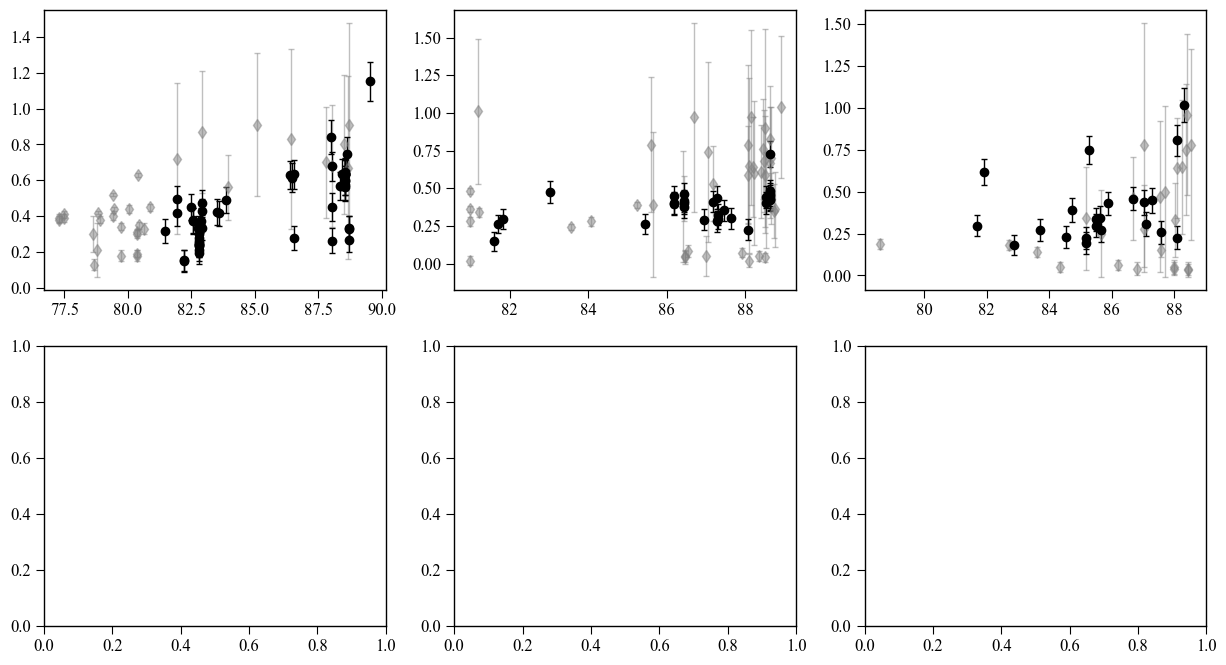

In [35]:
#### Now plot ###


figure_mosaic="""
ABC
DEF
"""
fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))
xlim=[74,91]
ylim=[0,1.5]


axes['A'].errorbar( sample_dict['LL4']['MI'][Fo_var_mi]* 100, sample_dict['LL4']['MI'][mi_data_col] / 1000, yerr=sample_dict['LL4']['MI'][mi_err_col]/ 1000, 
                   color='grey', label='MI', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['B'].errorbar( sample_dict['LL8']['MI'][Fo_var_mi]* 100, sample_dict['LL8']['MI'][mi_data_col] / 1000, yerr=sample_dict['LL8']['MI'][mi_err_col]/ 1000, 
                   color='grey', label='MI', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['C'].errorbar( sample_dict['LL7']['MI'][Fo_var_mi]* 100, sample_dict['LL7']['MI'][mi_data_col] / 1000, yerr=sample_dict['LL7']['MI'][mi_err_col]/ 1000, 
                   color='grey', label='MI', alpha=0.5,markerfacecolor='grey', marker='d', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)


axes['A'].errorbar( sample_dict['LL4']['FI'][Fo_var], sample_dict['LL4']['FI'][fi_data_col], yerr=sample_dict['LL4']['FI'][fi_err_col], 
                   color='k', label='FI', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['B'].errorbar( sample_dict['LL8']['FI'][Fo_var], sample_dict['LL8']['FI'][fi_data_col], yerr=sample_dict['LL8']['FI'][fi_err_col], 
                   color='k', label='FI', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)
axes['C'].errorbar( sample_dict['LL7']['FI'][Fo_var], sample_dict['LL7']['FI'][fi_data_col], yerr=sample_dict['LL7']['FI'][fi_err_col], 
                   color='k', label='FI', markerfacecolor='k', marker='o', ls='none', 
                   barsabove=False, elinewidth=1, capsize=2,zorder=-2)


norm_LL4=norm_colors(sample_dict['LL4']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])
norm_LL8=norm_colors(sample_dict['LL8']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])
norm_LL7=norm_colors(sample_dict['LL7']['FI'][xso2co2_col],series4max=sample_dict['LL4']['FI'][xso2co2_col],series4min=sample_dict['LL8']['FI'][xso2co2_col])

cmap=cm.inferno_r
cmap.set_bad('white')

## This actually plots data
axes['A'].scatter(sample_dict['LL4']['FI'][Fo_var], sample_dict['LL4']['FI'][fi_data_col],
            marker='o', edgecolor='k',color=cmap(norm_LL4))

axes['B'].scatter(sample_dict['LL8']['FI'][Fo_var], sample_dict['LL8']['FI'][fi_data_col],
            marker='o', edgecolor='k',color=cmap(norm_LL8))

axes['C'].scatter(sample_dict['LL7']['FI'][Fo_var], sample_dict['LL7']['FI'][fi_data_col],
            marker='o', edgecolor='k',color=cmap(norm_LL7))

## this is the colorbar

cbar_ax = fig.add_axes([0.055, 0.67, 0.005, 0.2])  # Adjust the position and size as needed

sca = cbar_ax.scatter([0] * 100, np.linspace(0, 1, 100), c=np.linspace(0, 1, 100), cmap=cmap)
cbar = plt.colorbar(sca, cax=cbar_ax)

cbar.set_label('SO$_2$ (mol%)') 
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
cbar.set_ticklabels([str(value) for value in np.round(np.linspace(0.1, 6.5, 6), 0)])


for axis_key in ['A', 'B', 'C']:
    axes[axis_key].set_xlim(xlim)
    axes[axis_key].set_ylim(ylim)
    axes[axis_key].set_xlabel(Fo_var)
    axes[axis_key].set_ylabel("Pressure (kbar)")
    if axis_key=='A':
        axes[axis_key].legend(loc='upper center',title='May 2018')
    if axis_key=='B':
        axes[axis_key].legend(loc='upper center',title='July 2018')
    if axis_key=='C':
        axes[axis_key].legend(loc='upper center',title='August 2018')



############################ NOW the stretching model subplots ###############################



#### PLOT RESULTS OF STRETCHING #####


seconds_in_e_year = 365.25 * 24 * 60 * 60


y_col='CO2 density (g/cm3)'
x_col='Time(s)'
twin_col='Calculated depths (km)'

xlabel4plot='Time(years)'
ylabel4plot='CO2 density (g/cm3)'
twinlabel4plot='Calculated depth (km)'

linecolor='midnightblue'
linecolor2='purple'
linewidth=0.5


axes['E'].plot(results_dict_stall['R0']['b0'][x_col]/seconds_in_e_year,results_dict_stall['R0']['b0'][y_col],color=linecolor2,linestyle=':',linewidth=linewidth,label=str(round(b0*10**6)))
axes['E'].plot(results_dict_stall['R0']['b1'][x_col]/seconds_in_e_year,results_dict_stall['R0']['b1'][y_col],color=linecolor2,linestyle='-.',linewidth=linewidth,label=str(round(b1*10**6)))
axes['E'].plot(results_dict_stall['R0']['b2'][x_col]/seconds_in_e_year,results_dict_stall['R0']['b2'][y_col],color=linecolor2,linestyle='--', linewidth=linewidth,label=str(round(b2*10**6)))
axes['E'].plot(results_dict_stall['R0']['b3'][x_col]/seconds_in_e_year,results_dict_stall['R0']['b3'][y_col],color=linecolor2,linestyle='-',linewidth=linewidth, label=str(round(b3*10**6)))

axes['E'].plot(results_dict_stall['R0_2']['b4'][x_col]/seconds_in_e_year,results_dict_stall['R0_2']['b4'][y_col],color=linecolor,linestyle=':',linewidth=linewidth)
axes['E'].plot(results_dict_stall['R0_2']['b5'][x_col]/seconds_in_e_year,results_dict_stall['R0_2']['b5'][y_col],color=linecolor,linestyle='-.',linewidth=linewidth)
axes['E'].plot(results_dict_stall['R0_2']['b6'][x_col]/seconds_in_e_year,results_dict_stall['R0_2']['b6'][y_col],color=linecolor,linestyle='--', linewidth=linewidth)
axes['E'].plot(results_dict_stall['R0_2']['b7'][x_col]/seconds_in_e_year,results_dict_stall['R0_2']['b7'][y_col],color=linecolor,linestyle='-',linewidth=linewidth)


twinax_E=axes['E'].twinx()

# ### FIll between lines
# cmap = plt.get_cmap('Blues_r')  # You can choose any colormap you prefer
# num_segments = 100  # You can adjust this to control the smoothness of the gradient

# for i in range(1, 4):
#     color = cmap(i / 4.0)  # Get a color from the colormap
#     label = str(R0_2 * 10**6)+' \u03BCm radius FI' if i == 1 else None
#     axes['E'].fill_between(results_dict_stall['R0_2']['b%d' % i][x_col] / seconds_in_e_year,
#                          results_dict_stall['R0_2']['b%d' % (i - 1)][y_col],
#                          results_dict_stall['R0_2']['b%d' % i][y_col],
#                          color=color,alpha=0.5,zorder=-1,edgecolor='none')

# cmap = plt.get_cmap('Purples_r')  # You can choose any colormap you prefer
# num_segments = 100  # You can adjust this to control the smoothness of the gradient

# for i in range(1, 4):
#     color = cmap(i / 4.0)  # Get a color from the colormap
#     label = str(R0 * 10**6)+' \u03BCm radius FI' if i == 1 else None
#     axes['E'].fill_between(results_dict_stall['R0']['b%d' % i][x_col] / seconds_in_e_year,
#                          results_dict_stall['R0']['b%d' % (i - 1)][y_col],
#                          results_dict_stall['R0']['b%d' % i][y_col],
#                          color=color,alpha=0.5,zorder=-1,edgecolor='none')

#### plot 'F'

linecolor='darkred'
linecolor2='orange'

axes['F'].plot(results_dict_surface['R0']['b0'][x_col]/day_in_sec,results_dict_surface['R0']['b0'][y_col],color=linecolor2,linestyle=':',linewidth=linewidth,label=str(round(b0*10**6)))
axes['F'].plot(results_dict_surface['R0']['b1'][x_col]/day_in_sec,results_dict_surface['R0']['b1'][y_col],color=linecolor2,linestyle='-.',linewidth=linewidth,label=str(round(b1*10**6)))
axes['F'].plot(results_dict_surface['R0']['b2'][x_col]/day_in_sec,results_dict_surface['R0']['b2'][y_col],color=linecolor2,linestyle='--', linewidth=linewidth,label=str(round(b2*10**6)))
axes['F'].plot(results_dict_surface['R0']['b3'][x_col]/day_in_sec,results_dict_surface['R0']['b3'][y_col],color=linecolor2,linestyle='-',linewidth=linewidth, label=str(round(b3*10**6)))

axes['F'].plot(results_dict_surface['R0_2']['b4'][x_col]/day_in_sec,results_dict_surface['R0_2']['b4'][y_col],color=linecolor,linestyle=':',linewidth=linewidth)
axes['F'].plot(results_dict_surface['R0_2']['b5'][x_col]/day_in_sec,results_dict_surface['R0_2']['b5'][y_col],color=linecolor,linestyle='-.',linewidth=linewidth)
axes['F'].plot(results_dict_surface['R0_2']['b6'][x_col]/day_in_sec,results_dict_surface['R0_2']['b6'][y_col],color=linecolor,linestyle='--', linewidth=linewidth)
axes['F'].plot(results_dict_surface['R0_2']['b7'][x_col]/day_in_sec,results_dict_surface['R0_2']['b7'][y_col],color=linecolor,linestyle='-',linewidth=linewidth)

twinax_F=axes['F'].twinx()

# ### FIll between lines
# cmap = plt.get_cmap('Reds_r')  # You can choose any colormap you prefer
# num_segments = 100  # You can adjust this to control the smoothness of the gradient

# for i in range(1, 4):
#     color = cmap(i / 4.0)  # Get a color from the colormap
#     label = str(R0_2 * 10**6)+' \u03BCm radius FI' if i == 1 else None
#     axes['F'].fill_between(results_dict_surface['R0_2']['b%d' % i][x_col] / day_in_sec,
#                          results_dict_surface['R0_2']['b%d' % (i - 1)][y_col],
#                          results_dict_surface['R0_2']['b%d' % i][y_col],
#                          color=color,alpha=0.5,zorder=-1,edgecolor='none')

# cmap = plt.get_cmap('Oranges_r')  # You can choose any colormap you prefer
# num_segments = 100  # You can adjust this to control the smoothness of the gradient

# for i in range(1, 4):
#     color = cmap(i / 4.0)  # Get a color from the colormap
#     label = str(R0 * 10**6)+' \u03BCm radius FI' if i == 1 else None
#     axes['F'].fill_between(results_dict_surface['R0']['b%d' % i][x_col] / day_in_sec,
#                          results_dict_surface['R0']['b%d' % (i - 1)][y_col],
#                          results_dict_surface['R0']['b%d' % i][y_col],
#                          color=color,alpha=0.5,zorder=-1,edgecolor='none')


##### Set the plot parameters 


ymin=np.nanmin([np.nanmin(results_dict_stall['R0']['b0'][y_col]),np.nanmin(results_dict_stall['R0_2']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]
xlim=([round(min(results_dict_stall['R0']['b0'][x_col]/seconds_in_e_year)),round(max(results_dict_stall['R0']['b0'][x_col]/seconds_in_e_year))])

ylim_P_E=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim),T_K=SC_temp+273.15)['P_MPa']

ylim_D_E=pf.convert_pressure_to_depth(P_kbar=ylim_P_E/100,
                model='ryan_lerner')


axes['E'].set_xlim(xlim)
axes['E'].set_ylim(ylim)


xlim_F=([round(min(results_dict_surface['R0']['b0'][x_col]/day_in_sec)),round(max(results_dict_surface['R0']['b0'][x_col]/day_in_sec))])
ymin_F=np.nanmin([np.nanmin(results_dict_surface['R0']['b0'][y_col]),np.nanmin(results_dict_surface['R0_2']['b0'][y_col])])

ylim_F=[ymin_F,fi_rho_initial_gcm3]
ylim_P_F=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim_F),T_K=SC_temp+273.15)['P_MPa']

ylim_D_F=pf.convert_pressure_to_depth(P_kbar=ylim_P_F/100,
                model='ryan_lerner')

axes['F'].set_xlim(xlim_F)
axes['F'].set_ylim(ylim_F)


def percent_drop(ylim, original_value):
    return 100-ylim*100/original_value

twinax_E.set_ylim(percent_drop(ylim_P_E,original_value=SC_pressure*100))
twinax_F.set_ylim(percent_drop(ylim_P_F,original_value=SC_pressure*100))

axes['E'].set_xlabel(xlabel4plot)
axes['F'].set_xlabel('Time(days)')

axes['E'].set_ylabel(ylabel4plot)
axes['F'].set_ylabel(ylabel4plot)

twinax_E.set_ylabel('Deviation from Entrapment Pressure (%)')
twinax_F.set_ylabel('Deviation from Entrapment Pressure (%)')

axes['E'].legend(title='Distance to defect (\u03BCm)')
axes['F'].legend(title='Distance to defect (\u03BCm)')

subplot_labels = ['A', 'B', 'C','D','E', 'F']
pos_e2h=(0.05,0.82)
label_positions = [pos_e2h, pos_e2h, pos_e2h, pos_e2h, pos_e2h, pos_e2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)


############################### other plot params################################################

error_arrow_stalling=[90,max(ylim_P_E)/100,np.diff(ylim_P_E/100)[0]]
error_arrow_quenching=[90.5,max(ylim_P_F)/100,np.diff(ylim_P_F/100)[0]]

axes['A'].plot([error_arrow_stalling[0],error_arrow_stalling[0]],[error_arrow_stalling[1],error_arrow_stalling[1]-error_arrow_stalling[2]],linewidth=2)
axes['A'].plot([error_arrow_quenching[0],error_arrow_quenching[0]],[error_arrow_quenching[1],error_arrow_quenching[1]-error_arrow_quenching[2]],linewidth=2,color='red')

fig.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# fig.savefig(figpath+'/'+"Fig4_FoP_stretching.pdf")

# FIG S8 supplement all KS MC

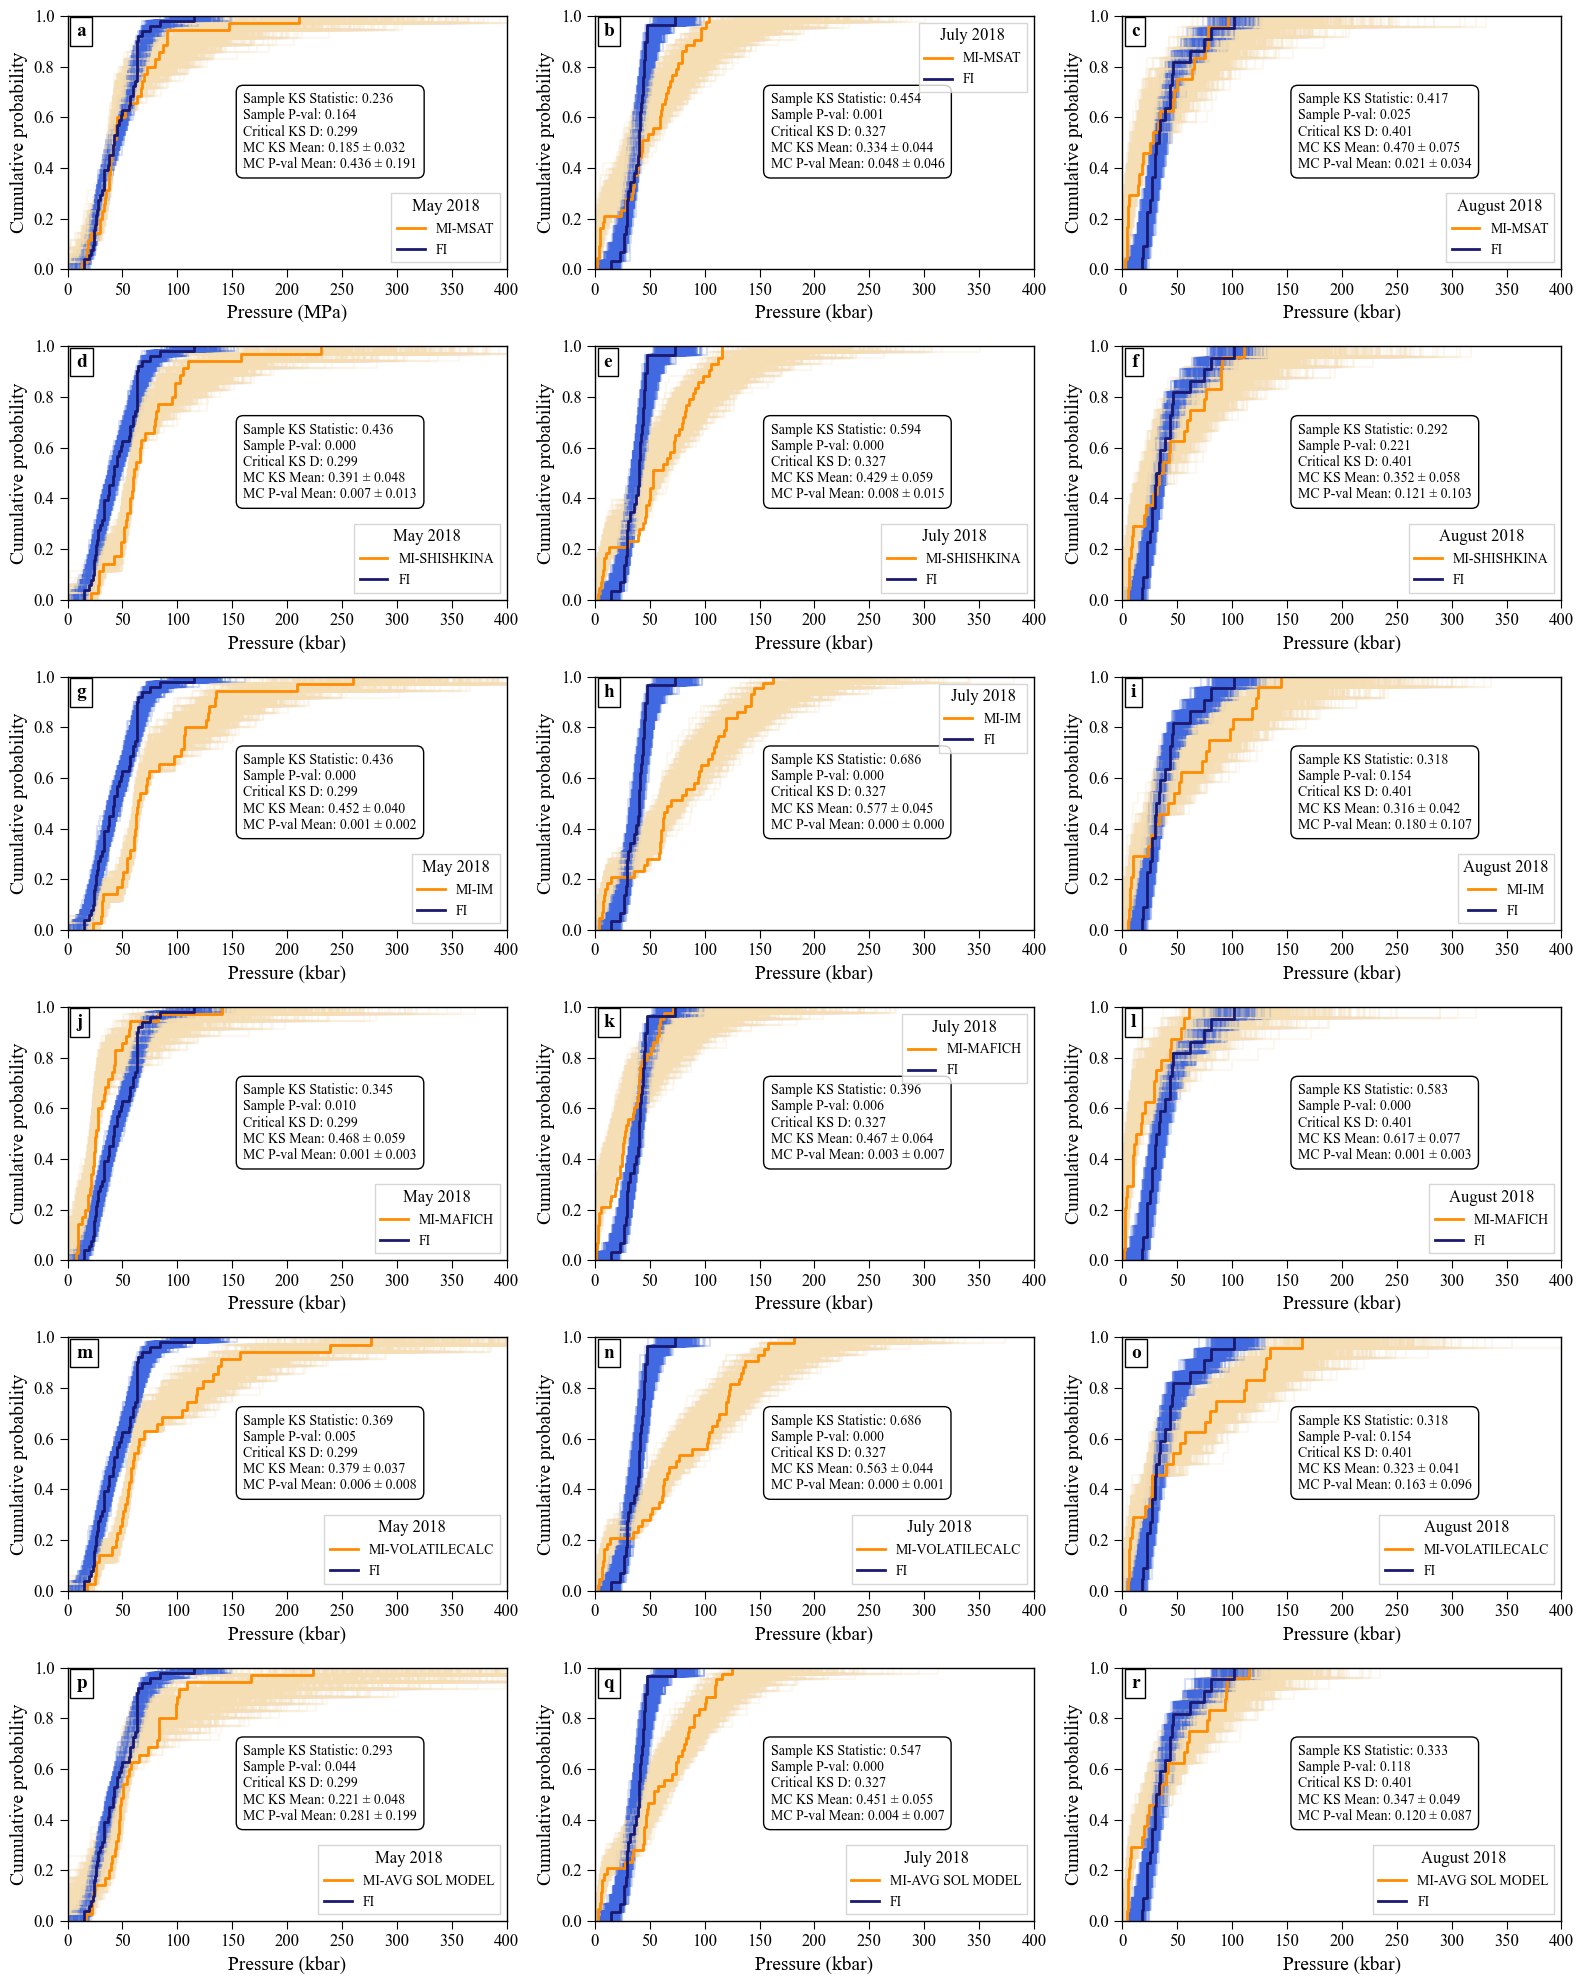

In [ ]:
## Now plot ##
figure_mosaic="""
ABC
DEF
GHI
JKL
MNO
PQR
"""

fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(16, 4*5))

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

plot_distribution(axes['A'], results_dict_mpa['LL4']['msat'], legend_title='May 2018', data1label='FI',data2label='MI-MSAT', xlabel='Pressure (MPa)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['B'], results_dict_mpa['LL8']['msat'], legend_title='July 2018', data1label='FI',data2label='MI-MSAT', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['C'], results_dict_mpa['LL7']['msat'], legend_title='August 2018', data1label='FI',data2label='MI-MSAT', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

plot_distribution(axes['D'], results_dict_mpa['LL4']['sh'], legend_title='May 2018', data1label='FI',data2label='MI-SHISHKINA', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['E'], results_dict_mpa['LL8']['sh'], legend_title='July 2018', data1label='FI',data2label='MI-SHISHKINA', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['F'], results_dict_mpa['LL7']['sh'], legend_title='August 2018', data1label='FI',data2label='MI-SHISHKINA', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

plot_distribution(axes['G'], results_dict_mpa['LL4']['im'], legend_title='May 2018', data1label='FI',data2label='MI-IM', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['H'], results_dict_mpa['LL8']['im'], legend_title='July 2018', data1label='FI',data2label='MI-IM', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['I'], results_dict_mpa['LL7']['im'], legend_title='August 2018', data1label='FI',data2label='MI-IM', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

plot_distribution(axes['J'], results_dict_mpa['LL4']['mch'], legend_title='May 2018', data1label='FI',data2label='MI-MAFICH', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['K'], results_dict_mpa['LL8']['mch'], legend_title='July 2018', data1label='FI',data2label='MI-MAFICH', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['L'], results_dict_mpa['LL7']['mch'], legend_title='August 2018', data1label='FI',data2label='MI-MAFICH', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

plot_distribution(axes['M'], results_dict_mpa['LL4']['vc'], legend_title='May 2018', data1label='FI',data2label='MI-VOLATILECALC', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['N'], results_dict_mpa['LL8']['vc'], legend_title='July 2018', data1label='FI',data2label='MI-VOLATILECALC', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['O'], results_dict_mpa['LL7']['vc'], legend_title='August 2018', data1label='FI',data2label='MI-VOLATILECALC', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

plot_distribution(axes['P'], results_dict_mpa['LL4']['avg'], legend_title='May 2018', data1label='FI',data2label='MI-AVG SOL MODEL', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['Q'], results_dict_mpa['LL8']['avg'], legend_title='July 2018', data1label='FI',data2label='MI-AVG SOL MODEL', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])
plot_distribution(axes['R'], results_dict_mpa['LL7']['avg'], legend_title='August 2018', data1label='FI',data2label='MI-AVG SOL MODEL', xlabel='Pressure (kbar)',xlim=[0, 400],ylim=[0, 1])

pos_a2h=(0.02,0.92)
label_positions = [pos_a2h, pos_a2h, pos_a2h,pos_a2h, pos_a2h, pos_a2h,pos_a2h, pos_a2h, pos_a2h,pos_a2h, pos_a2h, pos_a2h,pos_a2h, pos_a2h, pos_a2h,pos_a2h, pos_a2h, pos_a2h]

subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O','P','Q','R']

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)

fig.tight_layout()
fig.savefig(figpath+'/'+'FigS8_KSMC.png')
fig.savefig(figpath+'/'+'FigS8_KSMC.pdf')


## Fig S9 all sol models 

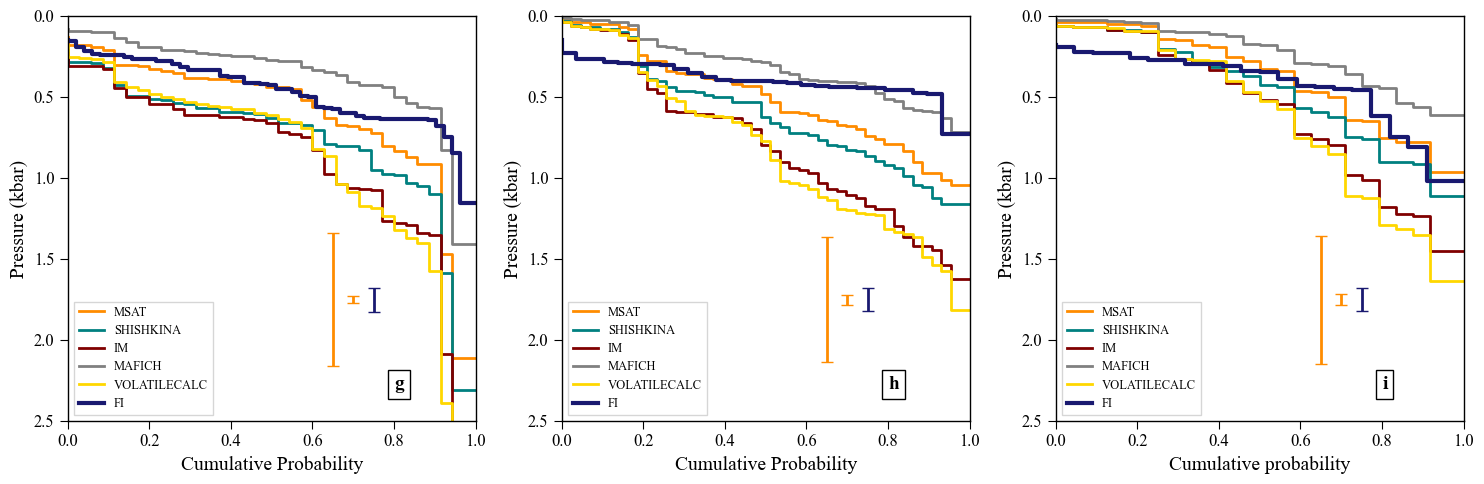

In [ ]:

### Here we plot everything together

x_MI_lei='Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)' #'Depth_RL(km)
x_FI='Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (kbar)'#'Mean_MC_D_km'


figure_mosaic="""
GHI
"""

fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 5))
val_lim=[2.5, 0]
val_lim_abc=[0,2.5]
proba_lim=[0,1]

fontsize=9
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')


##### PLOT D,E,F (CDF)#################################################################################################3



## LEI ##

# Plot data for ax 'G'
for key, value in data_and_properties.items():
    if key.endswith('_LL4'):  # Plot only sorted_lei_data on ax 'G'
        axes['G'].step(np.arange(value['data'].size + 1) / value['data'].size,
                       np.concatenate([value['data'], value['data'][-1:]]),
                       linewidth=value['properties']['linewidth'],
                       label=value['properties']['label'],
                       color=value['properties']['color'])

        if key.startswith('FI'):
            axes['G'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='k', alpha=0.3)
            axes['G'].errorbar(0.75,1.75,yerr=np.mean(value['error_data']),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2)
          
        else:
            axes['G'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='none', alpha=0.3)    
# Other plot settings for ax 'G'
axes['G'].set_xlabel('Cumulative Probability')
axes['G'].set_ylabel('Pressure (kbar)')
axes['G'].set_ylim(val_lim)  # Set y limits for pressure
axes['G'].set_xlim(proba_lim)  # Set xlimits for proba

# Plot data for ax 'H'
for key, value in data_and_properties.items():
    if key.endswith('_LL8'):  # Plot only sorted_lei_data on ax 'H'
        axes['H'].step(np.arange(value['data'].size + 1) / value['data'].size,
                       np.concatenate([value['data'], value['data'][-1:]]),
                       linewidth=value['properties']['linewidth'],
                       label=value['properties']['label'],
                       color=value['properties']['color'])
        if key.startswith('FI'):
            axes['H'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='k', alpha=0.3)

            axes['H'].errorbar(0.75,1.75,yerr=np.mean(value['error_data']),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2) 
        else:
            axes['H'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='none', alpha=0.3) 

# Other plot settings for ax 'H'
axes['H'].set_xlabel('Cumulative Probability')
axes['H'].set_ylabel('Pressure (kbar)')
axes['H'].set_ylim(val_lim)  # Set y limits for pressure
axes['H'].set_xlim(proba_lim)  # Set xlimits for proba
# Plot data for ax 'I'
for key, value in data_and_properties.items():
    if key.endswith('_LL7'):  # Plot only sorted_lei_data on ax 'I'
        axes['I'].step(np.arange(value['data'].size + 1) / value['data'].size,
                       np.concatenate([value['data'], value['data'][-1:]]),
                       linewidth=value['properties']['linewidth'],
                       label=value['properties']['label'],
                       color=value['properties']['color'])

        if key.startswith('FI'):
            axes['I'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='k', alpha=0.3)
            axes['I'].errorbar(0.75,1.75,yerr=np.mean(value['error_data']),capsize=4,fmt='',linestyle='',ecolor='midnightblue',elinewidth=2)                
        else:
            axes['I'].errorbar(np.arange(value['data'].size) / value['data'].size, value['data'],
                           yerr=0, fmt='none', ecolor='none', alpha=0.3) 
# Other plot settings for ax 'I'
axes['I'].set_xlabel('Cumulative probability')
axes['I'].set_ylabel('Pressure (kbar)')
axes['I'].set_ylim(val_lim)  # Set y limits for pressure
axes['I'].set_xlim(proba_lim)  # Set xlimits for proba

axes['G'].legend(loc='best',fontsize=fontsize)
axes['H'].legend(loc='best',fontsize=fontsize)
axes['I'].legend(loc='best',fontsize=fontsize)


#### PLOT FLOATING AVERAGE ERROR BARS FOR MI AND FI

MI_wDiad=mis_wMafiCH[~(mis_wMafiCH['CO2 in bubble (ppm)']<0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]
MI_noDiad=mis_wMafiCH[~(mis_wMafiCH['CO2 in bubble (ppm)']>=0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]
MI_wDiad=mis_wMafiCH[(mis_wMafiCH['CO2 in bubble (ppm)']>=0)][['Sample_ID','Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)','Magmasat_err4cdf']]

axes['G'].errorbar(0.65,1.75,yerr=np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL4')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['H'].errorbar(0.65,1.75,yerr=np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL8')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['I'].errorbar(0.65,1.75,yerr=np.mean(MI_wDiad[MI_wDiad['Sample_ID'].str.contains('LL7')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)

axes['G'].errorbar(0.7,1.75,yerr=np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL4')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['H'].errorbar(0.7,1.75,yerr=np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL8')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)
axes['I'].errorbar(0.7,1.75,yerr=np.mean(MI_noDiad[MI_noDiad['Sample_ID'].str.contains('LL7')]['Magmasat_err4cdf']/1000),capsize=4,fmt='',linestyle='',ecolor='darkorange',elinewidth=2)

#### PLOT SETTINGS ######################################################
subplot_labels = ['G','H','I']
pos_a2h=(0.8,0.08)
label_positions = [pos_a2h, pos_a2h, pos_a2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)
### SAVE FIG##############################################################

plt.tight_layout()

fig.savefig(figpath+'/'+"FigS9_CDF_allsolmods.png")
fig.savefig(figpath+'/'+"FigS9_CDF_allsolmods.pdf")


## Single FI plots for supplement

In [41]:
mifi_only.to_clipboard(excel=True)

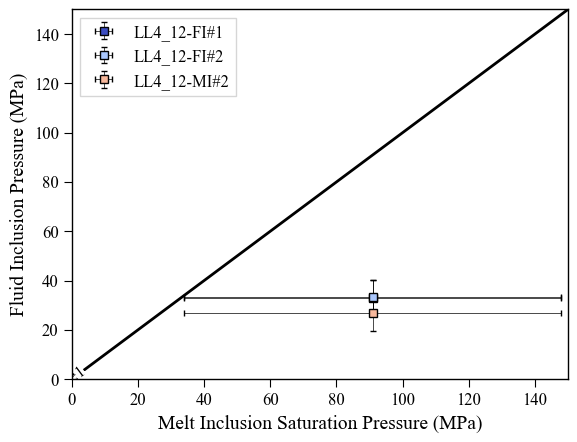

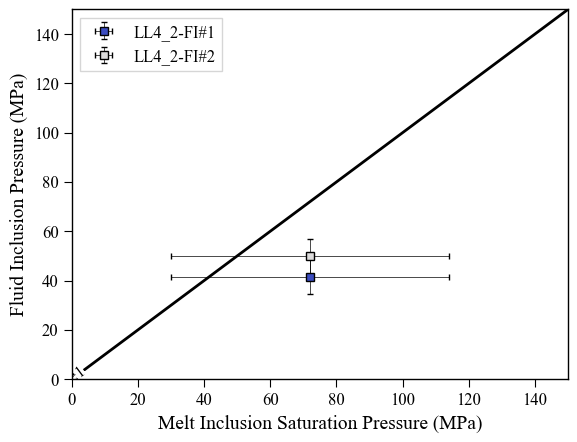

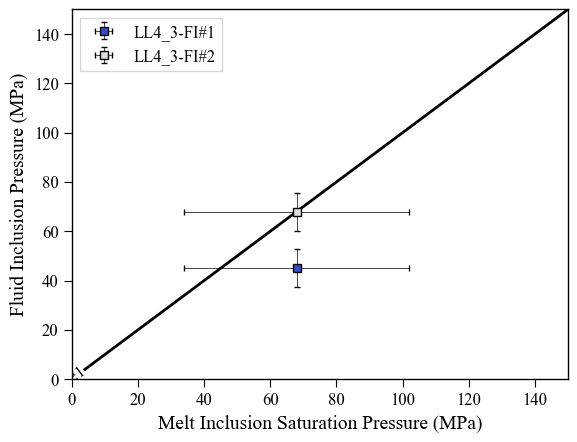

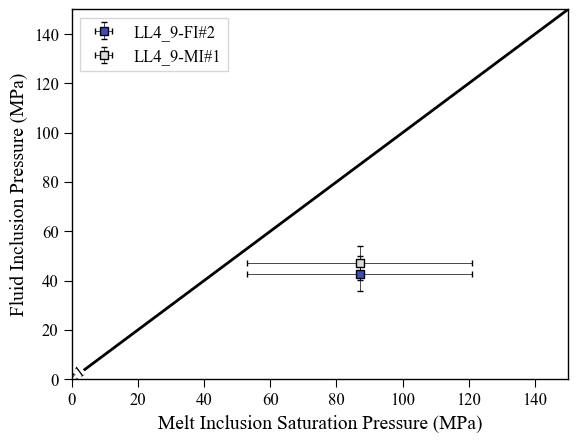

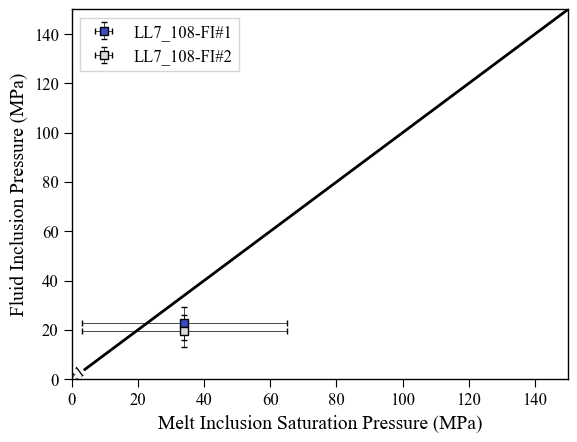

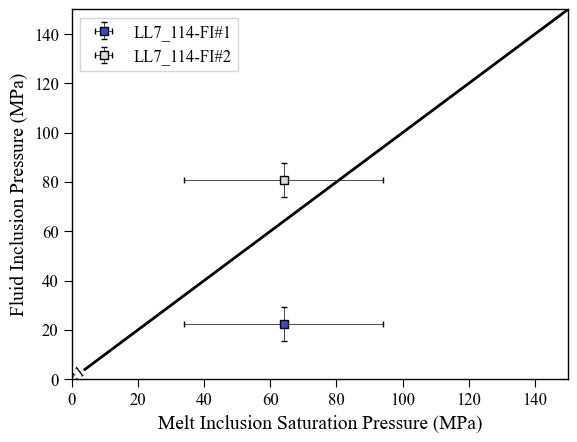

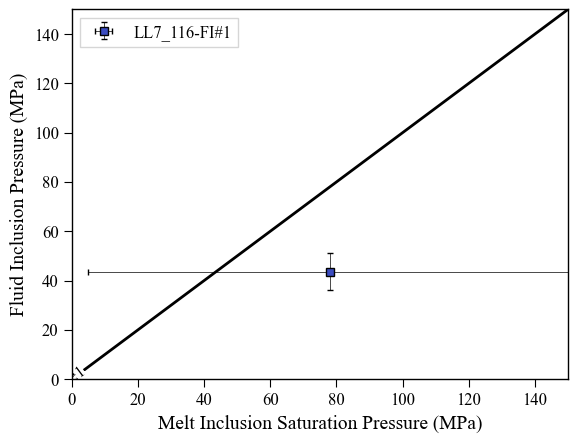

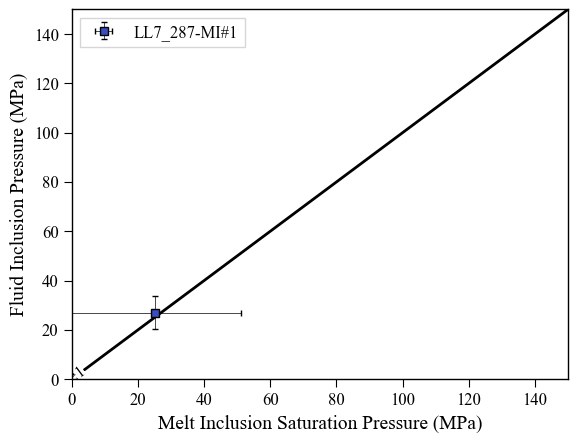

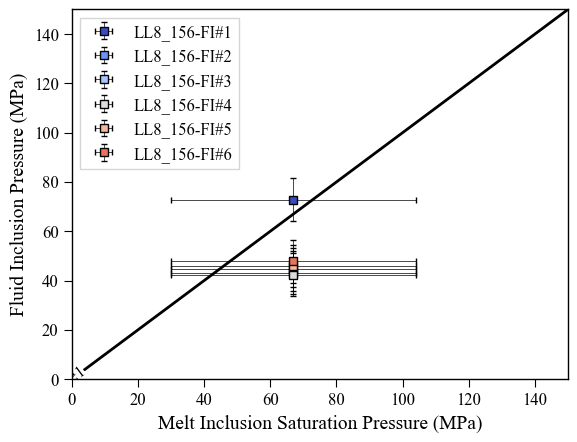

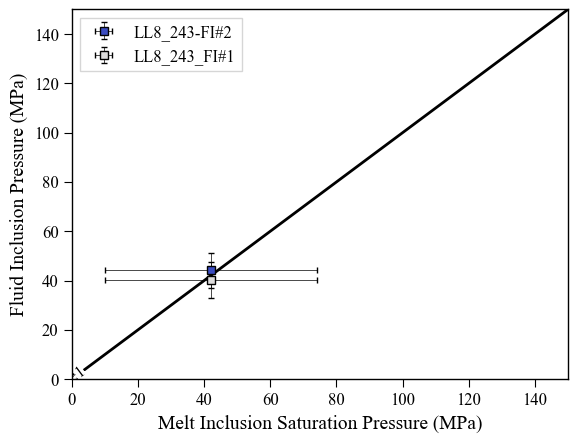

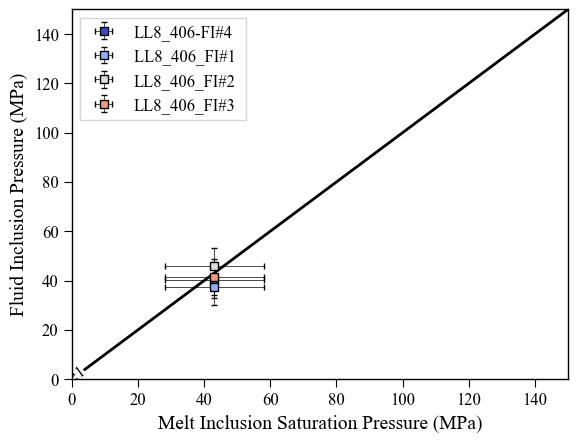

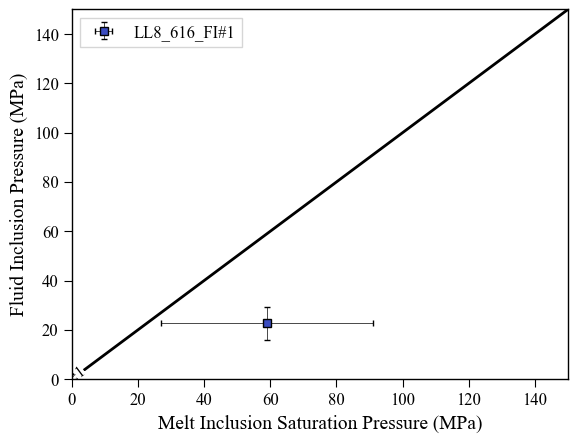

In [44]:
singleplots_folder = figpath + '/single_xtal_plots'  # where to save single crystal plots

if not os.path.exists(singleplots_folder):
    os.mkdir(singleplots_folder)

# MI_P_var = 'Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)'
# MI_P_err_var = 'Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)'
plot_var = 'Host crystal ID'
name_var = 'Fluid inclusion ID'
color_column='SO2_CO2_AreaRatio'

for sample in mifi_only[plot_var].unique():
    select_sample = sample
    mask = mifi_only[plot_var] == select_sample

    xlim = [0, 150]
    ylim = [0, 150]

    xerr = 'Sat_P_MI_kbar_err'
    yerr = 'Corrected Single Fluid Inclusion Pressure Mean Error (Mean of Lower and Upper error) (MPa)'

    # set up the plot
    fig, ax = plt.subplots()

    for idx, name in enumerate(mifi_only[mask][name_var].unique()):
        select_name = name
        name_mask = mifi_only[mask][name_var] == name
        x_coord = mifi_only[mask].loc[name_mask, 'Sat_P_MI_kbar'].iloc[0]*100
        y_coord = mifi_only[mask].loc[name_mask, 'Corrected Single Fluid Inclusion Pressure (preferred mean H2O) (MPa)'].iloc[0]

        # Generate a unique color for each data point
        # Generate a color using the "viridis" colormap
        color = plt.cm.coolwarm(idx / len(mifi_only[mask][name_var].unique()))

        ax.errorbar(x_coord, y_coord, xerr=mifi_only[xerr][mask].iloc[0]*100, yerr=mifi_only[yerr][mask].iloc[0],
                    fmt='s', linestyle='none', label=name, ecolor='k', elinewidth=0.5, capsize=2,
                    zorder=-2, color=color,mec='k')


    # add axis labels and limits
    ax.set_xlabel('Melt Inclusion Saturation Pressure (MPa)')
    ax.set_ylabel('Fluid Inclusion Pressure (MPa)')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend(loc='upper left')

    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]],'k',zorder=-3,linewidth=2,label="1:1")
    # ax.plot([xlim[0],xlim[1]],[xlim[0]+0.1*xlim[0],xlim[1]+0.1*xlim[1]],'grey',linestyle='-.',label="10%")
    # ax.plot([xlim[0],xlim[1]],[xlim[0]-0.1*xlim[0],xlim[1]-0.1*xlim[1]],'grey',linestyle='-.',label="10%")
    # ax.plot([xlim[0],xlim[1]],[xlim[0]+0.05*xlim[0],xlim[1]+0.05*xlim[1]],'grey',linestyle=':',label="5%")
    # ax.plot([xlim[0],xlim[1]],[xlim[0]-0.05*xlim[0],xlim[1]-0.05*xlim[1]],'grey',linestyle=':',label="5%")
    xvals=[0.95]#[0.9,0.75,0.8,0.8,0.83]
    labelLines(ax.get_lines(), zorder=2.5,xvals=xvals,fontsize=12)

    fig.savefig(singleplots_folder + '/' + 'MIFIplot_' + select_sample + '.pdf',transparent=True)
    fig.savefig(singleplots_folder + '/' + 'MIFIplot_' + select_sample + '.png',transparent=True)
